<h1 style='color:orange; font-weight:bold; text-align:center'>Investigating Key Themes in GoPay User Feedback: A Topic Modeling Approach</h1>

## **1 Introduction**
Since its release in Jul 2023 (GoTo, [2023](https://www.gotocompany.com/en/news/press/goto-financial-launches-the-gopay-app-in-indonesia-expanding-its-reach-to-indonesians-from-all-levels-of-society)), GoPay app, a popular digital payment in Indonesia, has been receiving a huge amount of reviews on Play Store. With thousand of reviews, manually analyzing reviews, representing user satisfaction or dissatisfaction, becomes challenging because of labor-intensive and time-consuming efforts. The Product Manager of this app wants to understand the most pressing concerns and most appreciated features of the app, helping them guide the app improvements but with such a challenge, missed opportunities for product improvements can happen. This situation requires another approach to understanding user reviews without utilizing huge resources to keep the cost minimum.

This project aims to identify recurring topics in the user app reviews to uncover insights regarding user satisfaction or frustrations, e.g., transaction speed, payment failure, login problems, by exploiting a quantitative text analysis and a predictive topic model. With such goal, the main focus of this project will be around predominant themes in the reviews to reveal usability, common complaints, and sentiment. The outcomes of this project are expected to support the Product Manager in making informed decision about the app improvements, prioritizing features, and resolving user pain points. 

To this end, a dataset obtained from [Pratama](https://www.kaggle.com/datasets/pratamas/gopay-app-reviews-bahasa-indonesia) on Kaggle was used to perform the analysis and topic modeling. This dataset contains 6 variables listed below:
- `at`: Time and date of the review
- `content`: Review content
- `score`: Rating score (1-5)
- `userName`: User who provide the reviews
- `reviewCreatedVersion`: App version
- `thumbsUpCount`: Number of likes on the reviews.

In [1]:
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates
from nltk import bigrams
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords
import nltk
# from langdetect import detect, DetectorFactory
# from langdetect.lang_detect_exception import LangDetectException
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import warnings

plt.style.use('ggplot')
pd.options.display.max_colwidth=50
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **2 General Overview**
Before performing an analysis, a general overview about the dataset should be obtained to understand the characteristics of the dataset, and address potential problems in the dataset. This section will inspect the cleanliness of the dataset by investigating the number of observations, number of features, data types, duplicates, missing values, and descriptive statistics.

In [2]:
# Load the dataset
df4 = pd.read_csv('../data/review_gopay_newest_sort.csv')

In [3]:
# create function to inspect df
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [4]:
# inspect dataframe
print(f'The dataframe contains {df4.shape[0]} rows and {df4.shape[1]} cols.')
print(f"- {len(df4.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df4.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df4)

The dataframe contains 123253 rows and 6 cols.
- 2 are numeric cols
- 4 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValue,Sample
0,userName,123253,object,0.00,0.0,1747,"[Pengguna Google, bang Kozu, fadilah saputra, ..."
1,content,123253,object,0.00,0.0,78431,"[Mantap, Bagus dan mudah digunakan, Good, Sang..."
2,score,123253,int64,0.00,0.0,5,"[5, 4, 1, 2, 3]"
3,thumbsUpCount,123253,int64,0.00,0.0,252,"[0, 1, 3, 11369, 2, 51, 10, 46, 204, 24, 19, 7..."
4,reviewCreatedVersion,123253,object,12.92,0.0,40,"[1.24.1, 1.23.0, nan, 1.26.1, 1.17.0, 1.15.1, ..."
5,at,123253,object,0.00,0.0,122902,"[2024-07-07 16:58:06, 2024-07-07 16:57:08, 202..."


**Note**
- The dataset consists of 6 variables in which 2 of them are numerical and 4 are categorical. Among these variables, `at` is misidentified as an object or categorical variable when it should have been a datetime. A conversion will be necessary to explore the trend of topics over time. This discussion can shed light on whether negative perceptions or specific problems with transactions persist over time.
- The dataset contains a big size of rows which potentially pose a challenge during searching the ideal number of topics using grid search. The size of dataset will also lead to high computational resource for t-distributed Stochastic Neighbor Embedding (henceforth, t-SNE) as this data reduction technique for visualizing local patterns (topic clusters) require intensive computational resource. For this reason, an implementation Principal Component Analysis (PCA) may be necessary to reduce the high-dimensional data prior to passing the data to t-SNE for visualizing the topic clusters.
- Variable `reviewCreatedVersion`, representing the app version, contains a high rate of missing values. A further exploration is needed to determine whether data imputation techniques are necessary to address the missing values.
- Duplicates are not present in the dataset. As shown on the dataframe above, all variables contain 0% of duplicates. For this reason, I will not perform further checking on duplicates.

In [5]:
# convert at to datetime
df4['at'] = pd.to_datetime(df4['at']).dt.date

In [6]:
# get descriptive statistics
df4.select_dtypes(include='number').describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
score,123253.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0
thumbsUpCount,123253.0,1.0,48.0,0.0,0.0,0.0,0.0,11369.0


**Note**
- In general, both numerical features do not seem to have normal distributions as shown by the central tendencies. Variable `score` has value range between 1 and 5, and the majority of rating scores are 5. With min 1, the percentile 25% until max value is 5, indicating the rating scores are clustered at the end of the distribution. Overall, this tendency might indicate majority of GoPay users are satisfied with the services they received on the app. 
- Values of variable `thumsUpCount`, unlike the rating scores, are centered around the lower end of the distribution. This means that while some reviews received a lot of thumbs up, most of them only got a few or even zeros.
- To check further whether the different tendencies really occur, data visualization techniques such as a boxplot or a histogram can be used to confirm. 

In [7]:
df_numeric = df4.select_dtypes(include='number')
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'skew': df_numeric.apply(lambda col: col.skew()).values,
    'kurtosis': df_numeric.apply(lambda col: col.kurtosis()).values
}).round(4)

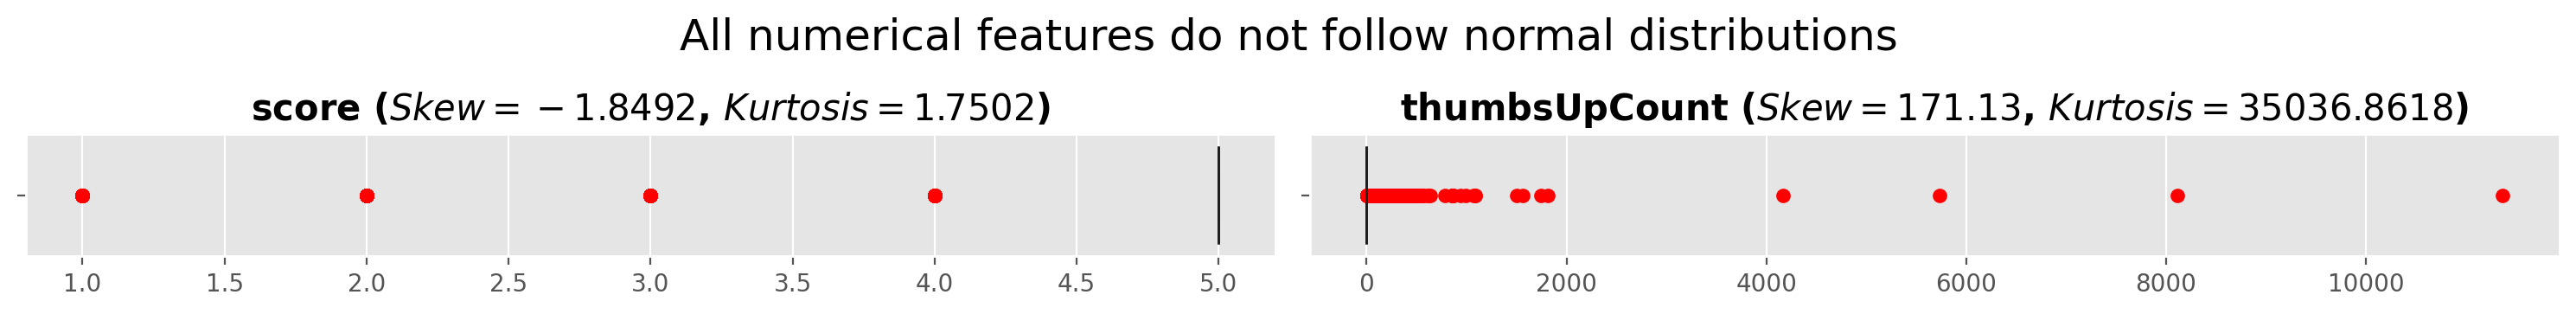

In [8]:
# visualize distributions
plt.figure(figsize=(15, 6), dpi=200)

for i, col in enumerate(df_numeric.columns):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x=df_numeric[col], color='darkgreen',
                flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, markersize=10))
    skew_value = stats_df.loc[stats_df['column'] == col, 'skew'].values[0]
    kurtosis_value = stats_df.loc[stats_df['column'] == col, 'kurtosis'].values[0]
    plt.title(f"{col} ($Skew = {skew_value}$, $Kurtosis = {kurtosis_value}$)", 
              size=15, fontweight='bold')
    plt.xlabel(None)
plt.suptitle('All numerical features do not follow normal distributions', size=18)
plt.tight_layout()
plt.show()

**Note**
- In line with the insights discovered in the previous descriptive statistics, the boxplots indicate different tendencies in variable `score` and `thumbsUpCount`. While values in `score` tend to pile up at the end of the higher end of the distribution (negatively skewed), those in `thumbsUpCount` are clustered at the lower end of the distribution (positively skewed).
- This insight, therefore, confirm the previous result that not only they have different tendencies but also do not follow normal distribution for the skewness.

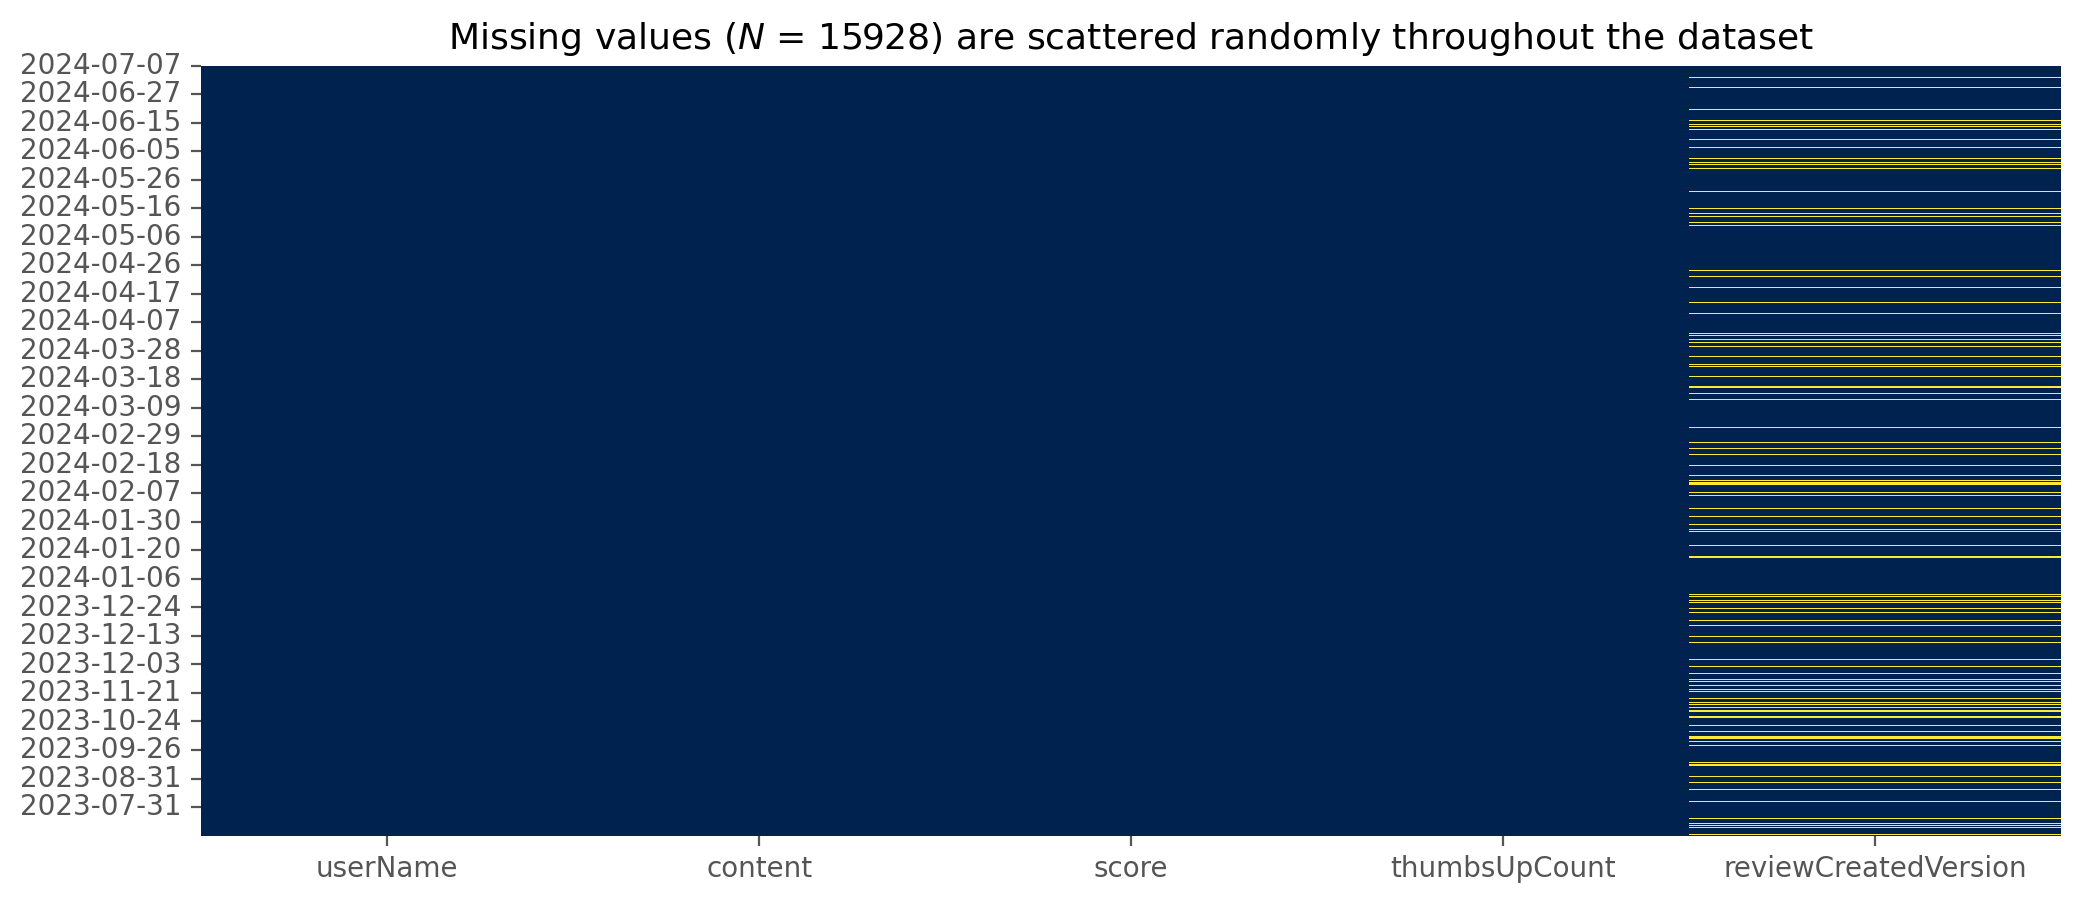

In [9]:
# check columns with missing values
plt.figure(figsize=(12, 5), dpi=200)
n_isna = df4['reviewCreatedVersion'].isna().sum()
sns.heatmap(df4.set_index('at').isna(), cmap=mpl.colormaps['cividis'], cbar=False)
plt.title(f'Missing values ($N$ = {n_isna}) are scattered randomly throughout the dataset', fontsize=13)
plt.ylabel(None)
plt.show()

**Note**: The number of missing values constitute 15,928 instances (12.92%) in `reviewCreatedVersion`. Due to the high number, discarding the instances cannot be an option because the removal can decrease a significant number of data. To address the missing values, I will perform data imputation with a constant categorical value, namely `Undefined`. The ultimate goal of this project is to understand the key themes in the reviews (`content`), making the app version not critical in this project.

In [10]:
# perform imputation
df4.loc[:, 'reviewCreatedVersion'] = df4['reviewCreatedVersion'].fillna('Undefined')

# double check missing valuees
df4.isna().mean()*100

userName                0.0
content                 0.0
score                   0.0
thumbsUpCount           0.0
reviewCreatedVersion    0.0
at                      0.0
dtype: float64

## **3 Exploratory Data Analysis**
The exploratory data analysis (EDA) will take a look at different aspects of the dataset such as user engagement, temporal analysis, and content analysis. The categorization here will make easier in drawing interpretations about the data. User engagement is concerned with the app user interaction with the service provider via the app. This aspect provides an understanding of their interaction levels with the app. For example, engaged users tend to write detailed reviews. Analyzing user engagement, especially satisfaction scores, which reflects how satisfied users with the app. Temporal analysis informs trends related to user satisfaction, frustration, or other changes. Moreover, version analysis helps in identifying specific features or bugs causing user frustration as well as positive experience. This enables the product team prioritize fixes and improvements or understand the effects of updates. Last, content analysis gives deeper insights about what users talking about but this is just a starting point since the main part of the project is done via topic modeling. The content analysis in EDA section is limited to frequency of words or word combinations. For this reason, they are analyzed without their immediate co-text. 

### **3.1 User Engagement**
#### **3.1.1 How many users give each score?**
This question deals with examining the overall satisfaction of the GoPay users. High rating (4-5) indicates high satisfaction level and positive user experience. Investigating the overall satisfaction levels tells whether the app meets user needs and expectations. For overall low ratings (1-2), investigating satisfaction scores is beneficial for the starting point of identifying user pain points or improvement areas. 

In [11]:
score_df = df4['score'].value_counts().reset_index().round(2)
total_count = score_df['count'].sum()

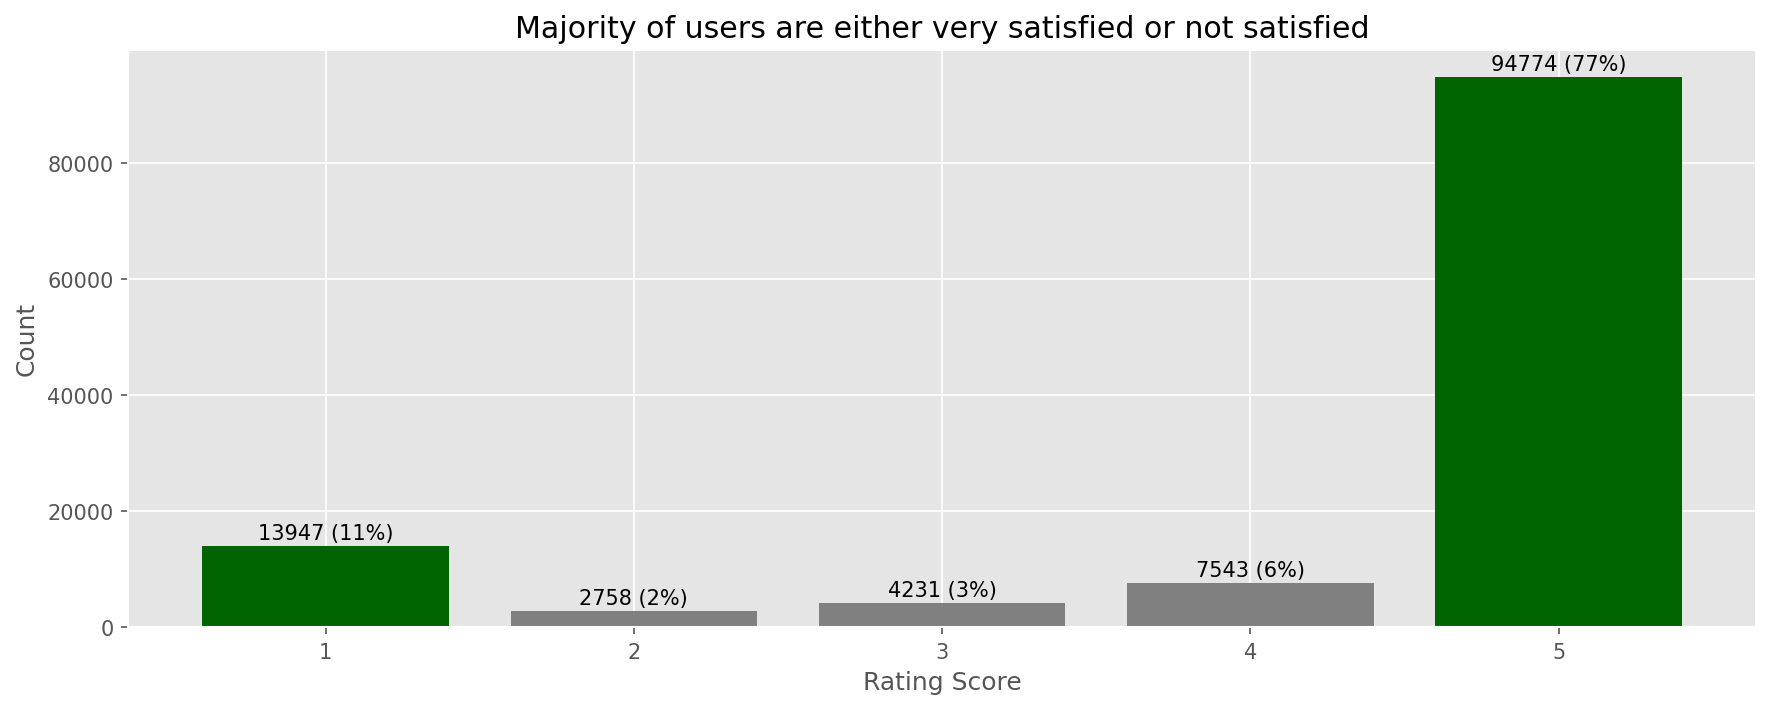

In [12]:
# create a color list for the bars
colors = ['darkgreen' if score in [1, 5] else 'grey' for score in score_df['score']]

# create the bar plot
plt.figure(figsize=(14, 5), dpi=150)
ax = plt.bar(score_df['score'], score_df['count'],
             color=colors)

for bar in ax:
    yval = bar.get_height()
    percentage = (yval / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 500,
             f'{yval} ({percentage:.0f}%)',
             ha='center', va='bottom')

plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.title('Majority of users are either very satisfied or not satisfied')
plt.xticks(score_df['score'])
plt.show()

**Note**
- Overall, the rating scores indicate high satisfaction levels among app users. The app users mostly provide 5 stars (77%) on the app store. The high level of satisfaction in general shows that the app can meet the users' expectactions. On the other hand, some work needs to be done to address 1 rating scores. In addition to rating 5, the majority of users also gave 1 rating scores, underscoring the need for focusing on the lower and higher end of the satisfaction rates.
- Given the overrepresentation of lower and higher end of satisfaction levels, we can see that a polarization effect can also be seen in the dataset. This situation occurs when ether users really love or hate the product are motivated to leave a review. Rating scores representing moderate or neutral opinion are less likely to occur.

#### **3.1.2 Are there any patterns in the reviewers?**

In [13]:
# Get the top users for score 1 and score 5
rating_score1 = (df4[df4['score'] == 1]['userName']
                 .value_counts(normalize=True)
                 .reset_index()
                 .round(4)
                 .head(10))
rating_score1['userName'] = rating_score1['userName'].apply(lambda x: x.lower())
rating_score1.columns = ['userName', 'percent']

rating_score5 = (df4[df4['score'] == 5]['userName']
                 .value_counts(normalize=True)
                 .reset_index()
                 .round(4)
                 .head(10))
rating_score5['userName'] = rating_score5['userName'].apply(lambda x: x.lower())
rating_score5.columns = ['userName', 'percent']

# convert percentages 100
rating_score1['percent'] *= 100
rating_score5['percent'] *= 100

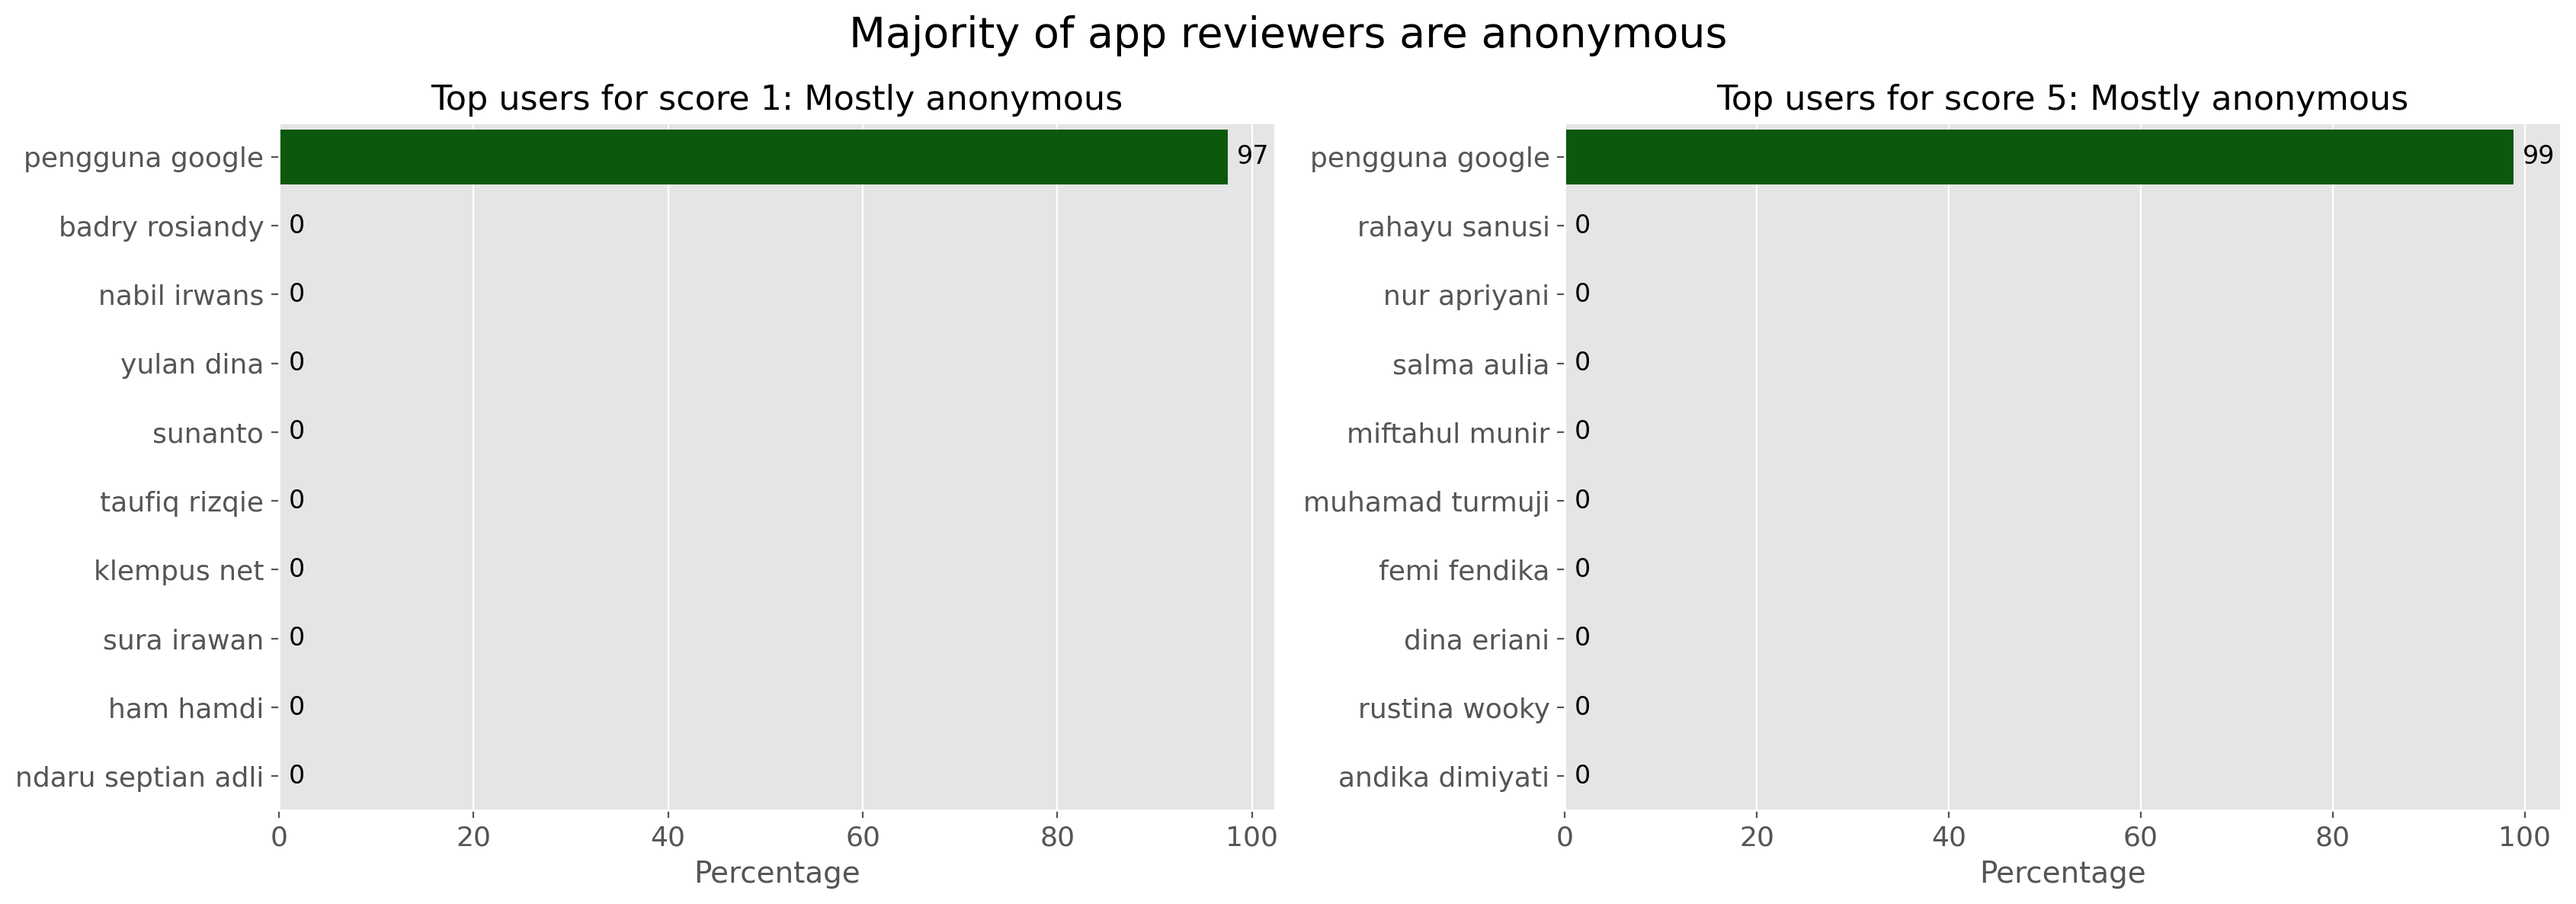

In [14]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 6), dpi=200)

# Horizontal bar plot for score 1
sns.barplot(x='percent', y='userName', data=rating_score1,
            ax=axes[0], color='darkgreen')
axes[0].set_title('Top users for score 1: Mostly anonymous', fontsize=16)
axes[0].set_xlabel('Percentage', fontsize=14)
axes[0].set_ylabel(None)
for index, value in enumerate(rating_score1['percent']):
    axes[0].text(value + 1, index, f'{value:.0f}', va='center', fontsize=12)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='x', labelsize=13)

# Horizontal bar plot for score 5
sns.barplot(x='percent', y='userName', data=rating_score5,
            ax=axes[1], color='darkgreen')
axes[1].set_title('Top users for score 5: Mostly anonymous', fontsize=16)
axes[1].set_xlabel('Percentage', fontsize=14)
axes[1].set_ylabel(None)
for index, value in enumerate(rating_score5['percent']):
    axes[1].text(value + 1, index, f'{value:.0f}', va='center', fontsize=12)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)

plt.suptitle('Majority of app reviewers are anonymous', size=20)
plt.tight_layout()
plt.show()

**Note**: This question aims to identify which users provide more reviews than the rest. As shown by the bar chart, it appears that the majority of reviewers are `pengguna google` (Google Users). The insight highlights the app store policy in which the same user can only provide one review. Despite its policy, the result remains providing a good insight, showing that most app users who left reviews are anonymous. However, it is unclear whether those who use anonymous usernames mostly indicate high or low satisfaction. 

In [15]:
# filter Pengguna Google
pengguna_google = ((df4[df4['userName'] == 'Pengguna Google']['score']
                    .value_counts(normalize=True)*100)
                   .reset_index()
                   .round(2))

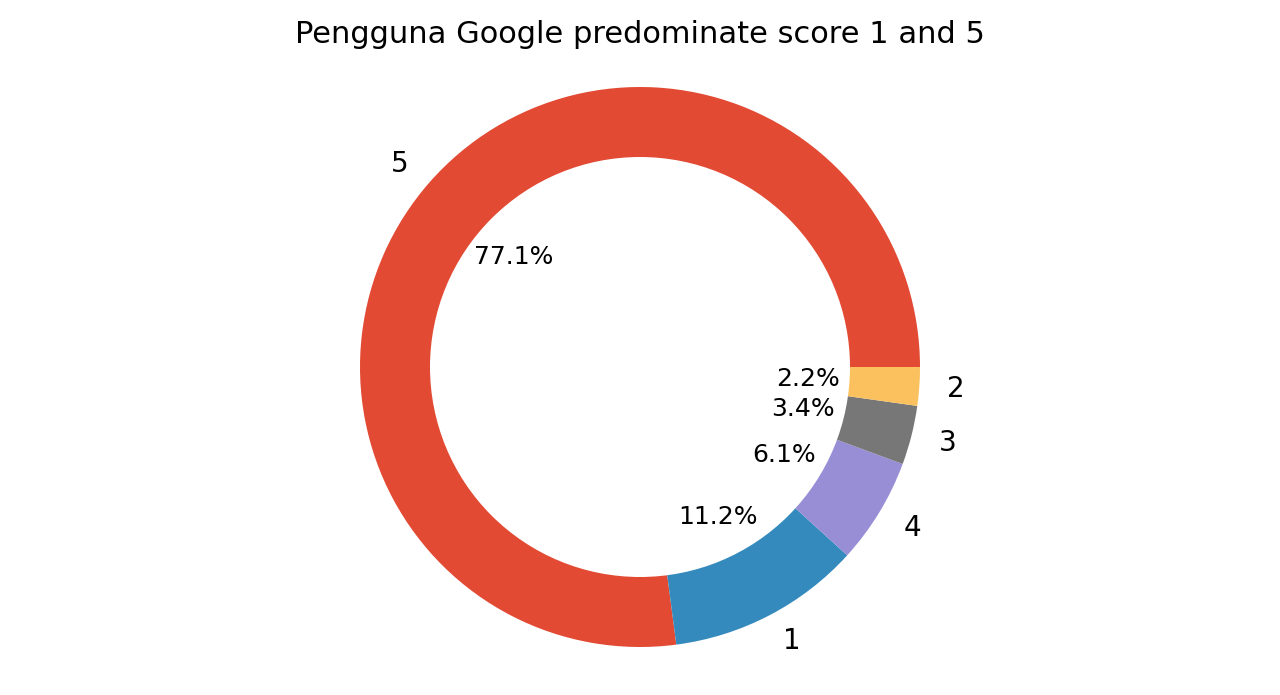

In [16]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
wedges, texts, autotexts = ax.pie(pengguna_google['proportion'], 
                                  labels=pengguna_google['score'], 
                                  autopct='%1.1f%%', startangle=0)
# set the font size 
for autotext in autotexts:
    autotext.set_fontsize(9)  

# add a circle to the center
centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig.gca().add_artist(centre_circle)
ax.axis('equal')  
plt.title("Pengguna Google predominate score 1 and 5", size=11)
plt.show()


**Note**: It turns out that the patterns are similar to the overall satisfaction scores in which Pengguna Google predominate rating score 1 and 5. This condition implies that in spite of using anonymous username, they remain showing high satisfaction.

#### **3.1.2 Which reviews have the most thumbs up?**
Thumbs up count illuminates the common consensus of the app reviewers. For example if the reviews with the most thumbs up has the low rating scores (1-2), these reviews might indicate critical problems affecting a large portion of app users. On the contrary, if those with high number of thumbs up have high rating scores (4-5), this situation might underscores well-loved features. The insight of this exploration help product managers prioritize feature improvement or bug fixes based on what resonates most with the consensus.

In [17]:
(df4.nlargest(n=5, columns='thumbsUpCount')
 .iloc[:, 0:4]
 .style.background_gradient(subset=['thumbsUpCount'], cmap='YlOrRd'))

,userName,content,score,thumbsUpCount
539,Pengguna Google,"WOI banget aplikasi ini, semua fungsi e banking bisa dilakukan di sini. Transfer ke semua rekening bank lancar real time dan gratis. Selain transfer bisa juga bayar rekening listrik, telepon, internet, PDAM, top up e wallet dll. Bukti bayar atau transfer dgn mudah dishare ke WA dll. Setelah sempat hilangkan nama tujuan transfer, skrg sdh muncul lagi. Saatnya kembali gunakan Gopay..",5,11369
84341,Pengguna Google,"Semua fiturnya gampang buat digunakan, tampilan UI nya buat pemula kayak saya cukup oke sih, gampang di pahami. Kemarin nyobain top up masuknya cepet, oh iya ada banyak promo juga buat pengguna baru, sejauh ini belum nemu bug sih",5,8109
47854,Pengguna Google,"Sudah cukup baik, permudah pengguna dalam lakukan transaksi keuangan khususnya, baik top up maupun transaksi pembayaran2, tingkatkan terus , cuma sayangnya saya yg tdk pernah telat apalagi nunggak bayaran paylater & selalu bayar penuh, tetap saja susah dapatin fasilitas Gopay Pinjam apalagi limit paylater yg besar. Mohon perhatiannya, sukses selalu",5,5736
113082,Pengguna Google,"Aplikasinya bagus banget dan ngebantu banget, kalau mau beli pulsa atau paket data jadi lebih gampang, bisa bayar listrik juga, mau transfer uang juga mudah dan ga ada biaya transfernya juga, mantap pokoknya.fitur didalamnya juga simpel tapi tetep modern,.. Pokoknya rekomended banget deh gopay ini☺️",5,4169
105623,Pengguna Google,"Aplikasinya bener"" memudahkan banget transfer tanpa ribet, buat beli pulsa dan daya juga tinggal klik"" , trus mau transfer pun gada biaya admin. bayar listrik juga bisa ih suka banget. fitur"" nya juga gampang dipahami rekomended banget deh pokoknya.",5,1810


**Note**
- The dataframe above lists top-five app reviews with the highest thumbs up count. Based on the rating scores, the top-five reviews with the largest number of thumbs up (thefore considered as the consensus of the app users) are 5, indicating that the common agreement of the users about the app is positive. In these top reviews, the users praise the app for its functionalities such as free and fast bank transfer; multipurpose transactions; and intuitive user interface.
- One user pain point also appears here although the user remains providing high score. The complaint is about the hardship for getting GoPay loan service (ID 47854). This review has been upvoted for 5,7 thousand times by other users, highlighting the possibility of similar cases by other users and the need for the product managers or relevant stakeholders to check the current policy of the loan service.
- Even though the top-five reviews already indicate the common consensus about the app from users, the general pattern of the thumbs up count by scores have not yet been obtained. To do this, a follow up analysis can be done by summing the thumbs up counts by the scores.

In [18]:
# sum thumbs up by scores
thumbsup_df = df4.groupby('score', as_index=False).agg({'thumbsUpCount': 'sum'})
thumbsup_df['score'] = thumbsup_df['score'].astype(str)
thumbsup_df = thumbsup_df.sort_values(by='thumbsUpCount', ascending=False)

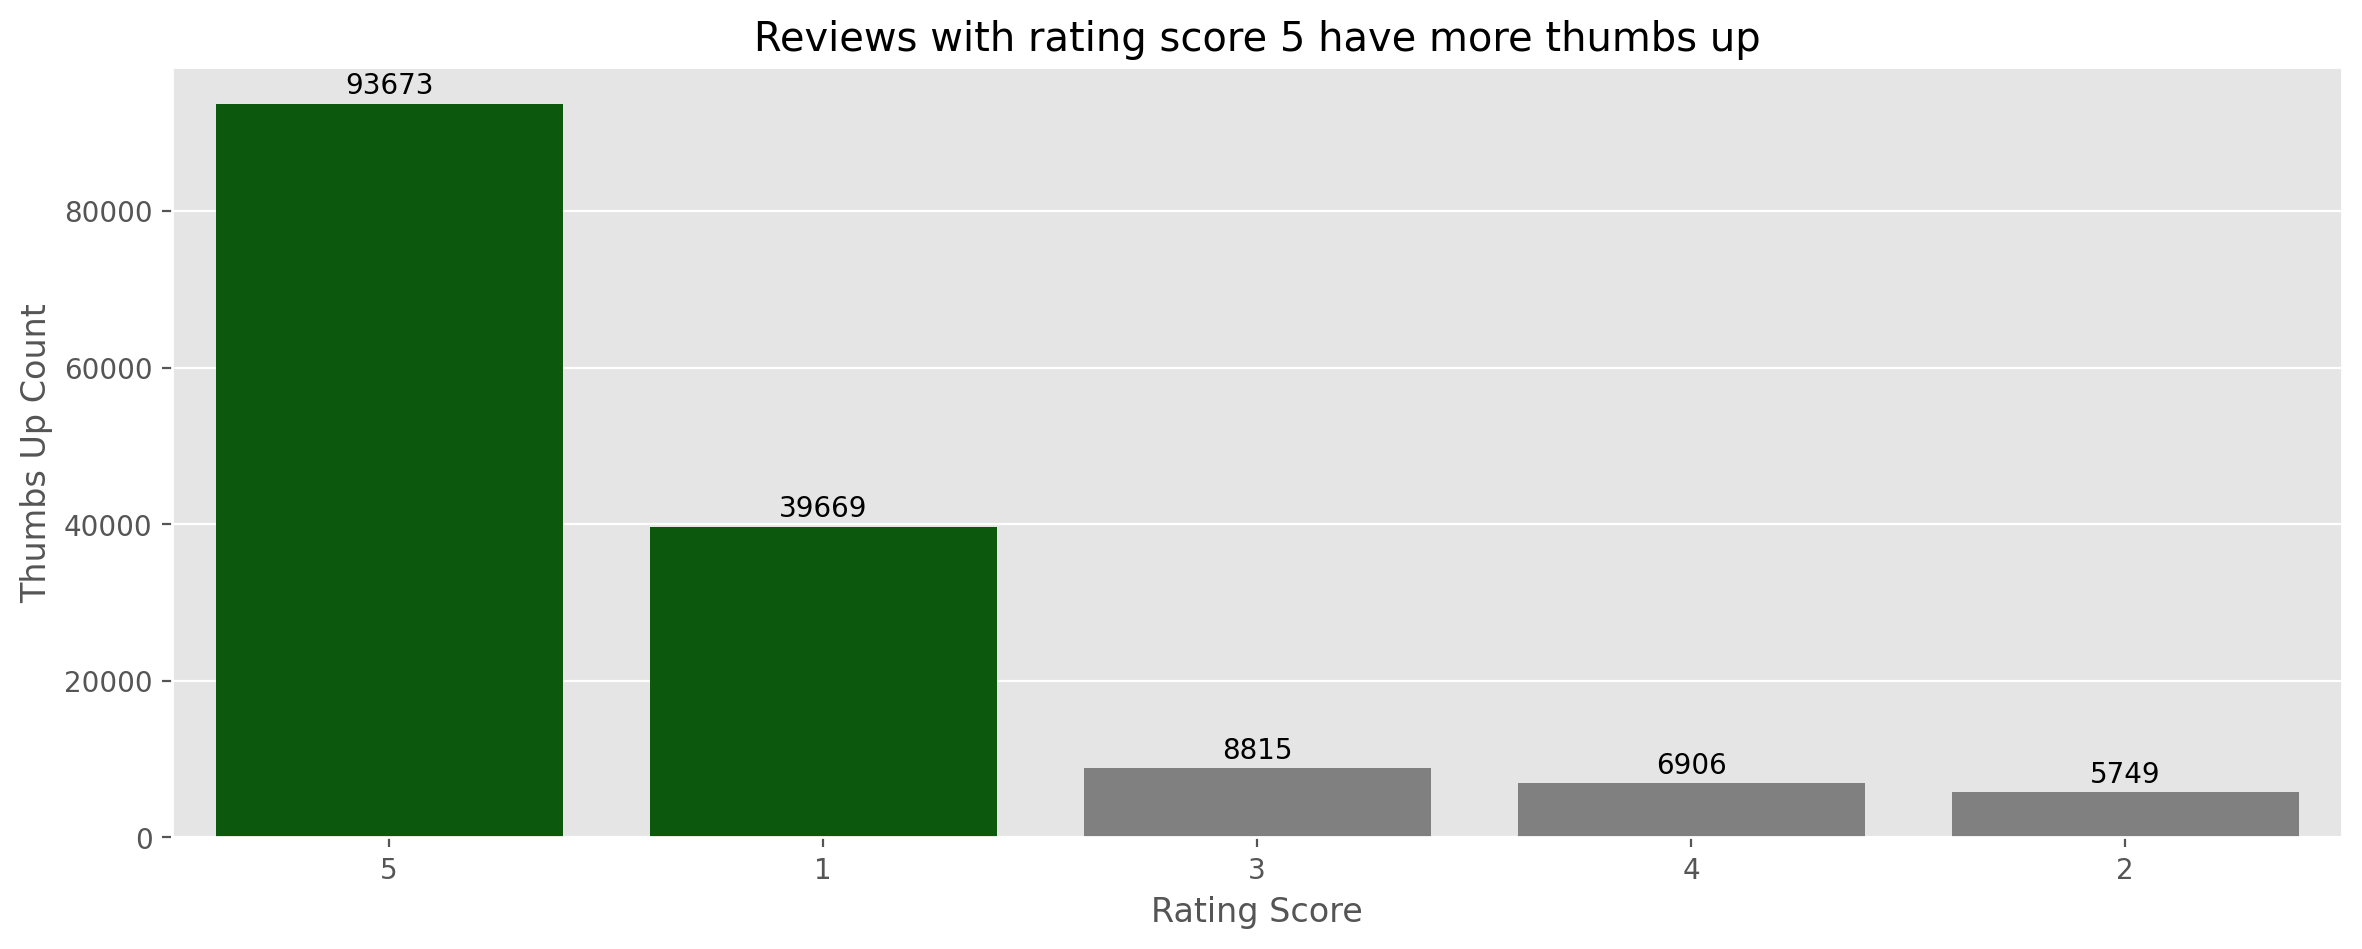

In [19]:
highlight_colors = ['darkgreen' if topic in ['1', '5'] else 'grey' for topic in thumbsup_df['score']]

plt.figure(figsize=(14, 5), dpi=200)
sns.barplot(y='thumbsUpCount', x='score', data=thumbsup_df, legend=False, hue='score', palette=highlight_colors)
# Add data labels on top of the bars
for index, value in enumerate(thumbsup_df['thumbsUpCount']):
    plt.text(index, value + 500, str(value), ha='center', va='bottom', fontsize=10)
plt.title('Reviews with rating score 5 have more thumbs up')
plt.xlabel('Rating Score')
plt.ylabel('Thumbs Up Count')
plt.show()

**Note**: Since the general pattern of satisfaction shows polarity, this condition is reflected in the thumbs up count. Here, the general pattern is also rating score 5, obtaining higher number of thumbs up. Bearing this pattern in mind, this situation overall implies that the general consensus about the app from users is positive.

### **3.2 Temporal Analysis**
The purpose of the emporal anaysis is to find out the distribution of scores over time. This analysis is particularly useful if there is any specific bug fixes done in the past and the technical team aims to see the effect of the fixes. But for product managers, temporal analysis provides an understanding of how high or low satisfaction shift over time, assisting them to make informed decisions about feature rollouts. My analysis will focus on the distribution of scores over time to investigate whether there are significant changes in the user satisfaction.

#### **3.2.1 Are there any temporal patterns in user rating scores?**

In [20]:
# prepare dataset
df4['at'] = pd.to_datetime(df4['at'])
daily_scores = df4.groupby(df4['at'].dt.date)['score'].mean().reset_index()

# Calculate IQR for the scores
Q1 = daily_scores['score'].quantile(0.25)
Q3 = daily_scores['score'].quantile(0.75)
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

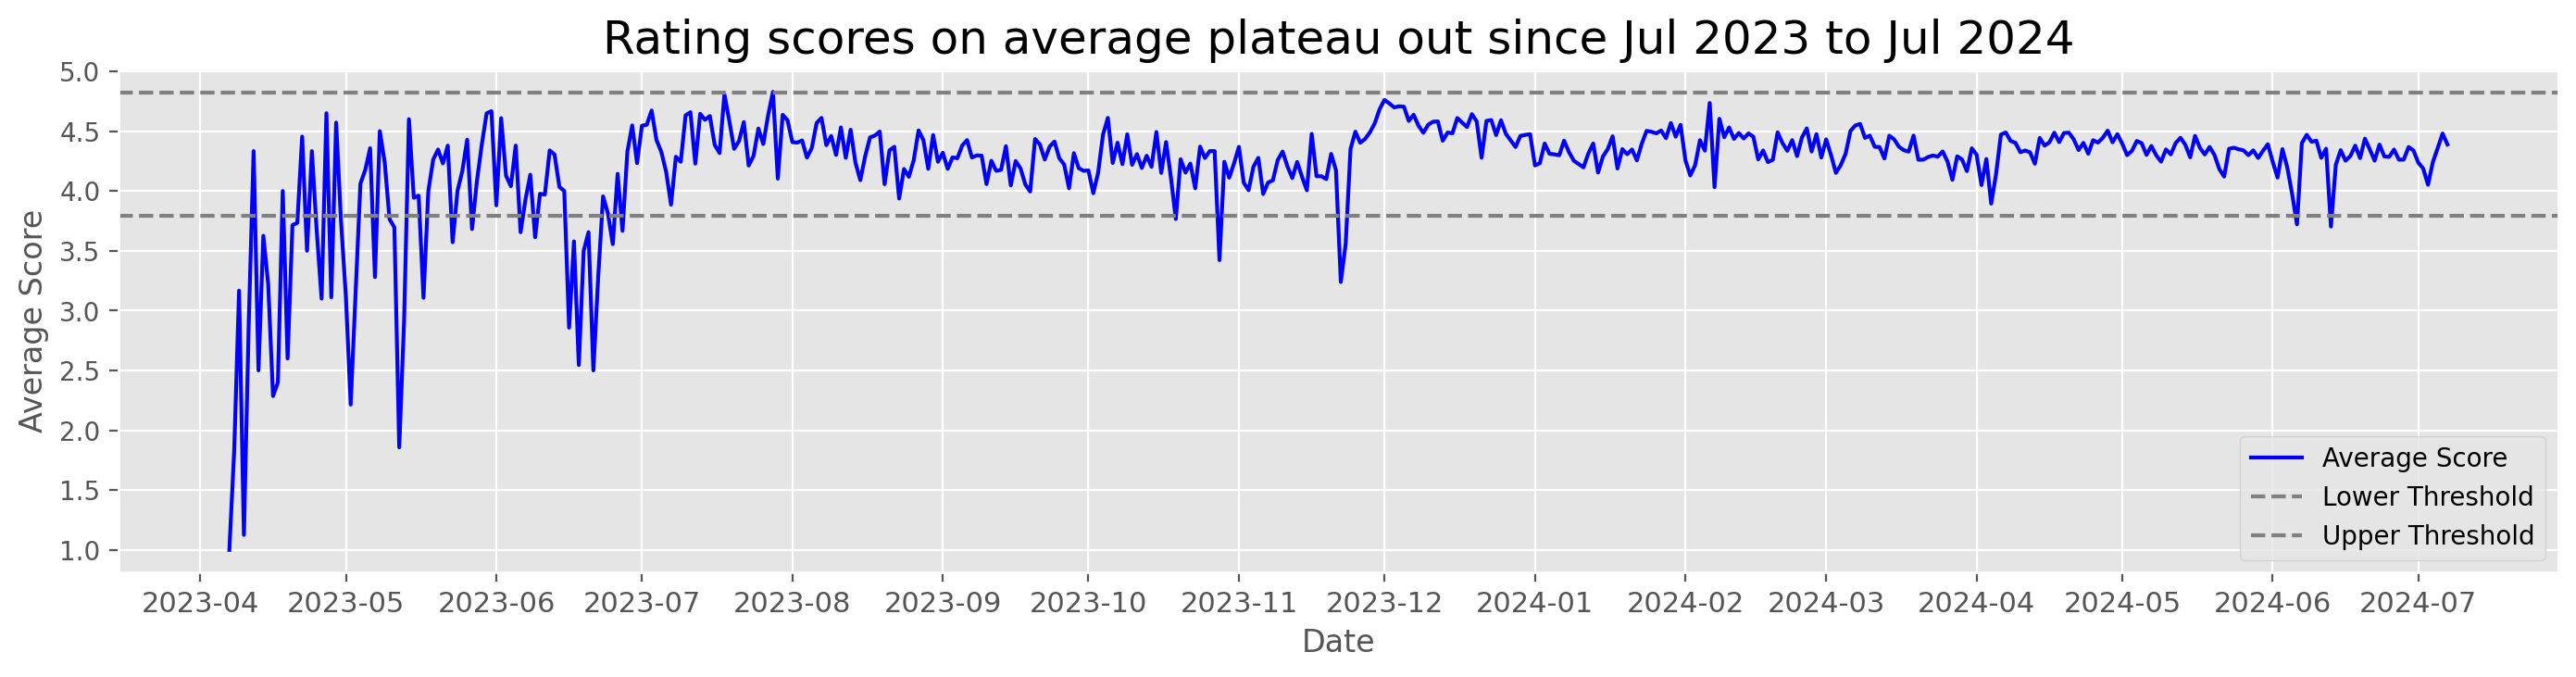

In [21]:
# plotting
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(daily_scores['at'], daily_scores['score'],
         linestyle='-', color='b', label='Average Score')
plt.axhline(lower_threshold, color='grey', linestyle='--', label='Lower Threshold')
plt.axhline(upper_threshold, color='grey', linestyle='--', label='Upper Threshold')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.title('Rating scores on average plateau out since Jul 2023 to Jul 2024', size=18)
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.xticks(rotation=0, fontsize=11, ha='center')
plt.legend()
plt.grid(True)
plt.show()

**Note**
- The line chart above summarizes the changes in mean rating scores over time. In general, prior to Jul 2023, the mean rating scores underwent significant fluctuations in which the lowest mean rating scores (around 1.0) were given in the early Apr 2023, and then started increasing over time. The trend of mean rating scores plateaued out after Jul 2023 to Jul 2024.
- The details for the fluctuations can be seen on the heatmap below. The heatmap suggests that the mean review scores peaked in Jul 2023 and Dec 2023 with scores of 4.5 and 5.6, respectively. However, the peaks are not significantly different from the rest, indicating overall, the user satisfaction remains high over time.

In [22]:
df4['month'] = df4['at'].dt.month
df4['year'] = df4['at'].dt.year
pivot_df = df4.pivot_table(values='score', index='year', columns='month', aggfunc='mean')

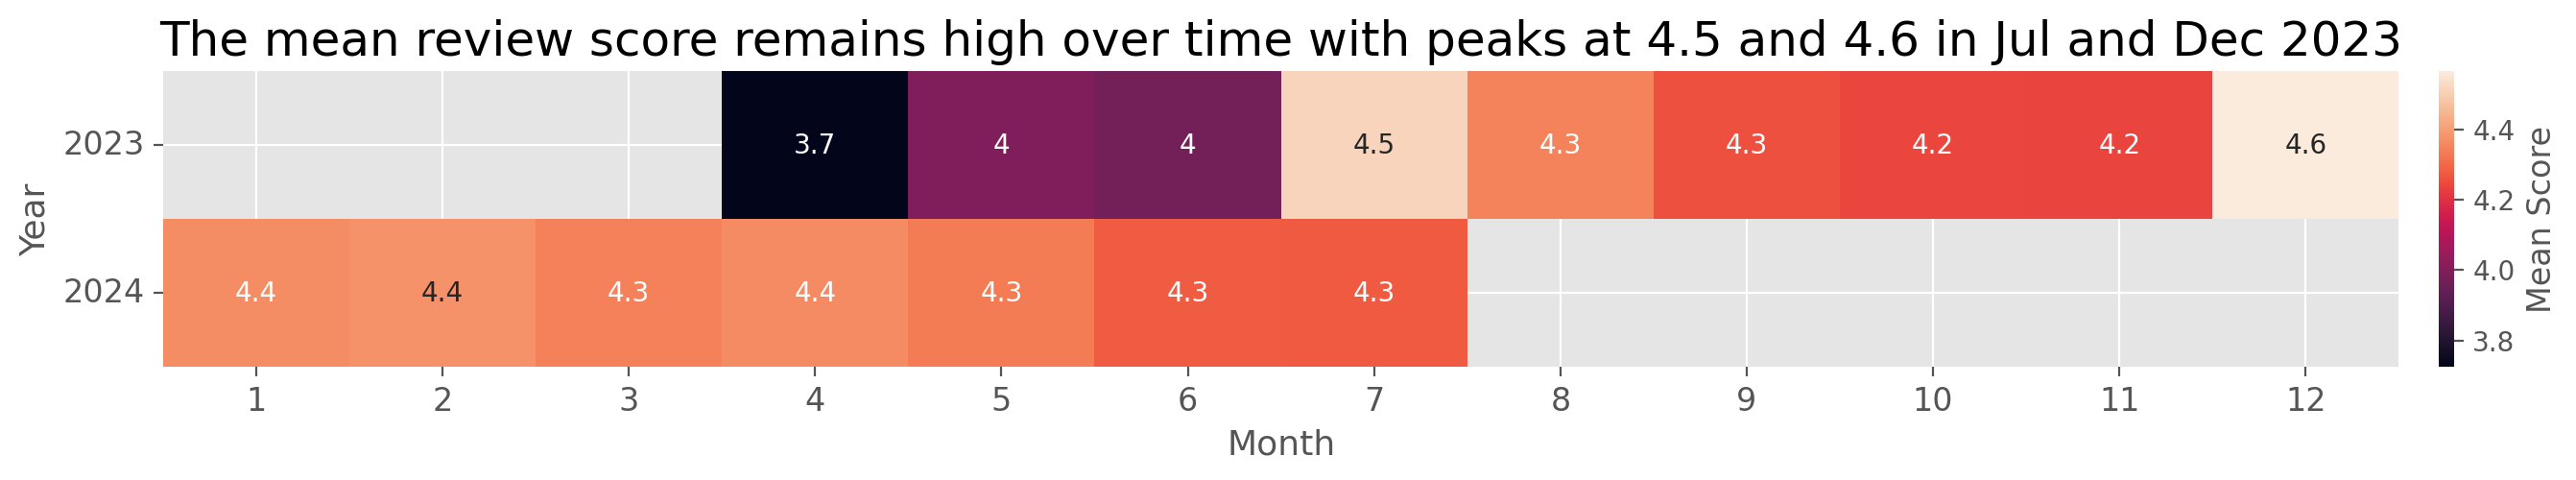

In [23]:
plt.figure(figsize=(18, 2), dpi=200)
sns.heatmap(pivot_df, annot=True, cbar_kws={'label':'Mean Score', 'pad': 0.015})
plt.title('The mean review score remains high over time with peaks at 4.5 and 4.6 in Jul and Dec 2023', 
          size=18)
plt.ylabel('Year', size=13)
plt.xlabel('Month', size=13)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.show()

In [24]:
# specify versions 
desired_versions = ((df4['reviewCreatedVersion'].value_counts(normalize=True)*100)
                    .reset_index()
                    .round(2)
                    .iloc[:5, 0]
                    .values)

# filter df for specific versions
filtered_df = df4[df4['reviewCreatedVersion'].isin(desired_versions)].copy()

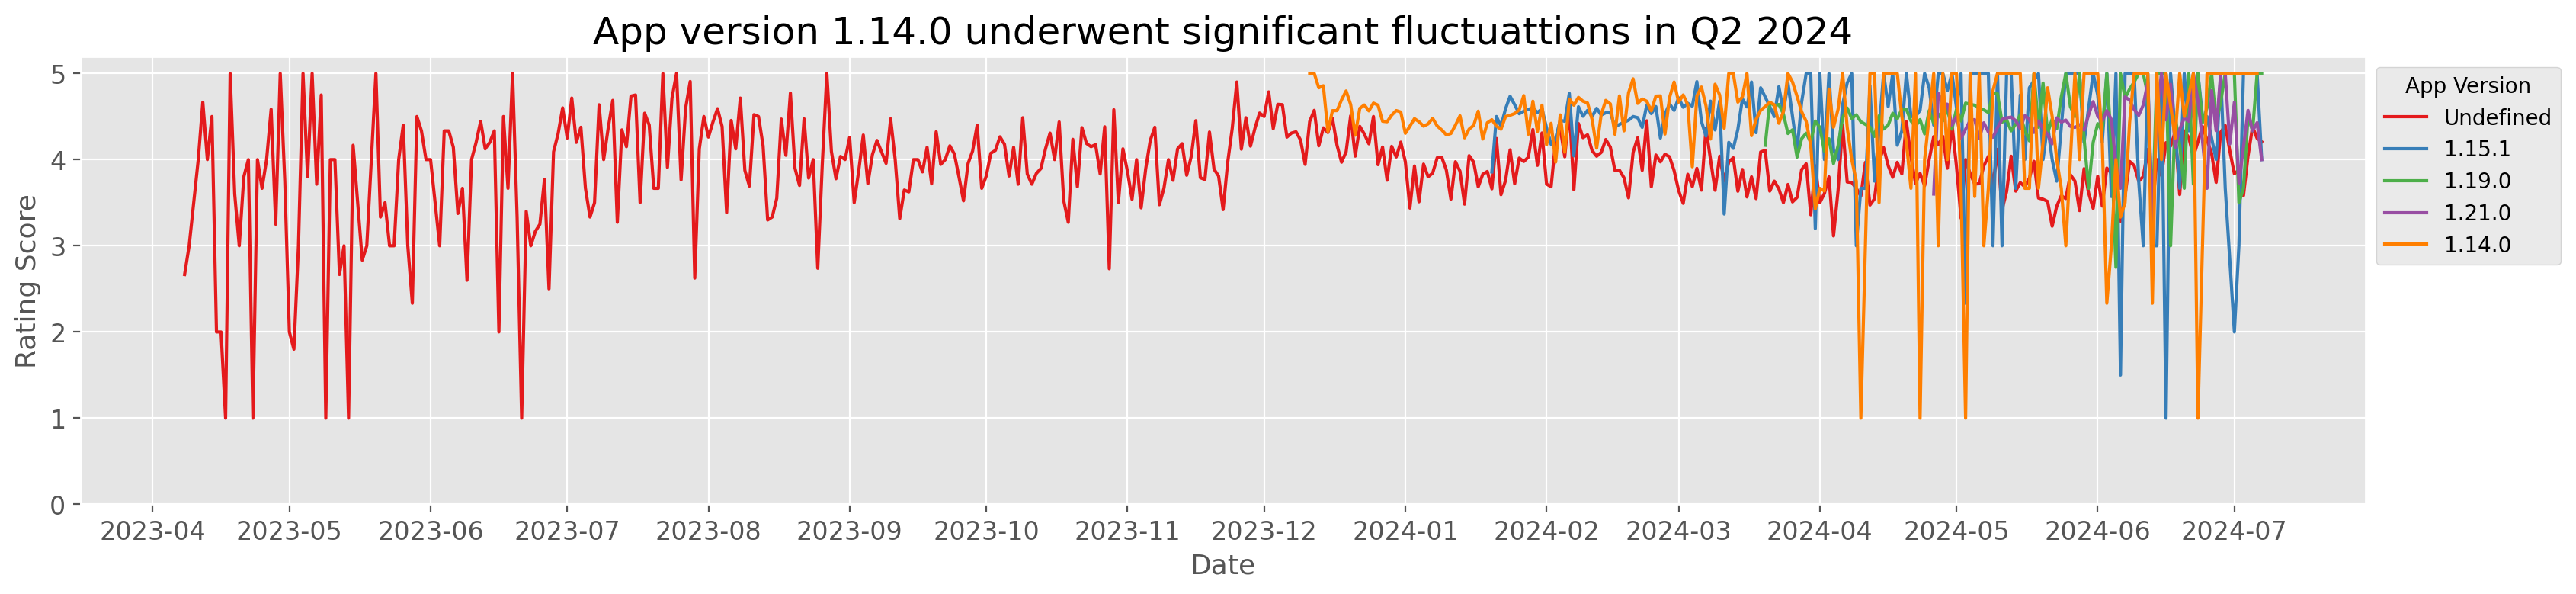

In [25]:
# Plotting
plt.figure(figsize=(17, 4), dpi=200)
sns.lineplot(data=filtered_df, x='at', y='score', hue='reviewCreatedVersion', 
             palette='Set1', errorbar=None)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
# Add labels and title
plt.title('App version 1.14.0 underwent significant fluctuattions in Q2 2024', size=18)
plt.xlabel('Date', size=13)
plt.ylabel('Rating Score', size=13)
plt.yticks(np.arange(0, 5.5, 1.0), size=12)
plt.xticks(rotation=0, ha='center', size=12)
plt.legend(title='App Version', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

**Note**
- The previous line chart already provides a understanding of cummulative mean of satisfaction scores but has not indicated the changes in rating scores by app versions. Here, I attempt to explore how the changes of satisfaction scores according to app versions, and since there are many app versions, I focus the analysis on the top-five app versions with the largest number of occurrences, namely `Undefined`, `1.15.1`, `1.90`, `1.21.0`, and `1.14.0`. Since the earliest app version is `1.0.0` and the latest version recorded is `1.24.1`, the top-5 version mostly contain th earlier versions of the app.
- Moreover, based on the line chart, it is app version `1.14.0` that received varying satisfaction scores with the lowest in Q2 of 2024.
- The `Undefined` version also underwent significant fluctuations but only in the beginning. After Jul 2023, it started plateauing out until Jul 2024. And since it is unclear what version it is, more attention can be given to version `1.14.0` with significant fluctuations in Q2 2024. Unlike the later versions (`1.190` and `1.210`), the fluctuation in `1.14.0` are greater. This situation may also indicate as more app updates were deployed, the app becomes more stable and the rating scores tend to be more constant around 4.0.

In [26]:
# extract month and year 
filtered_df['month_year'] = filtered_df['at'].dt.to_period('M')

# calculate the mean score by time and version
monthly_trend = filtered_df.groupby(['month_year', 'reviewCreatedVersion'])['score'].mean().reset_index()

# convert time back to datetime for plotting
monthly_trend['month_year'] = monthly_trend['month_year'].dt.to_timestamp()

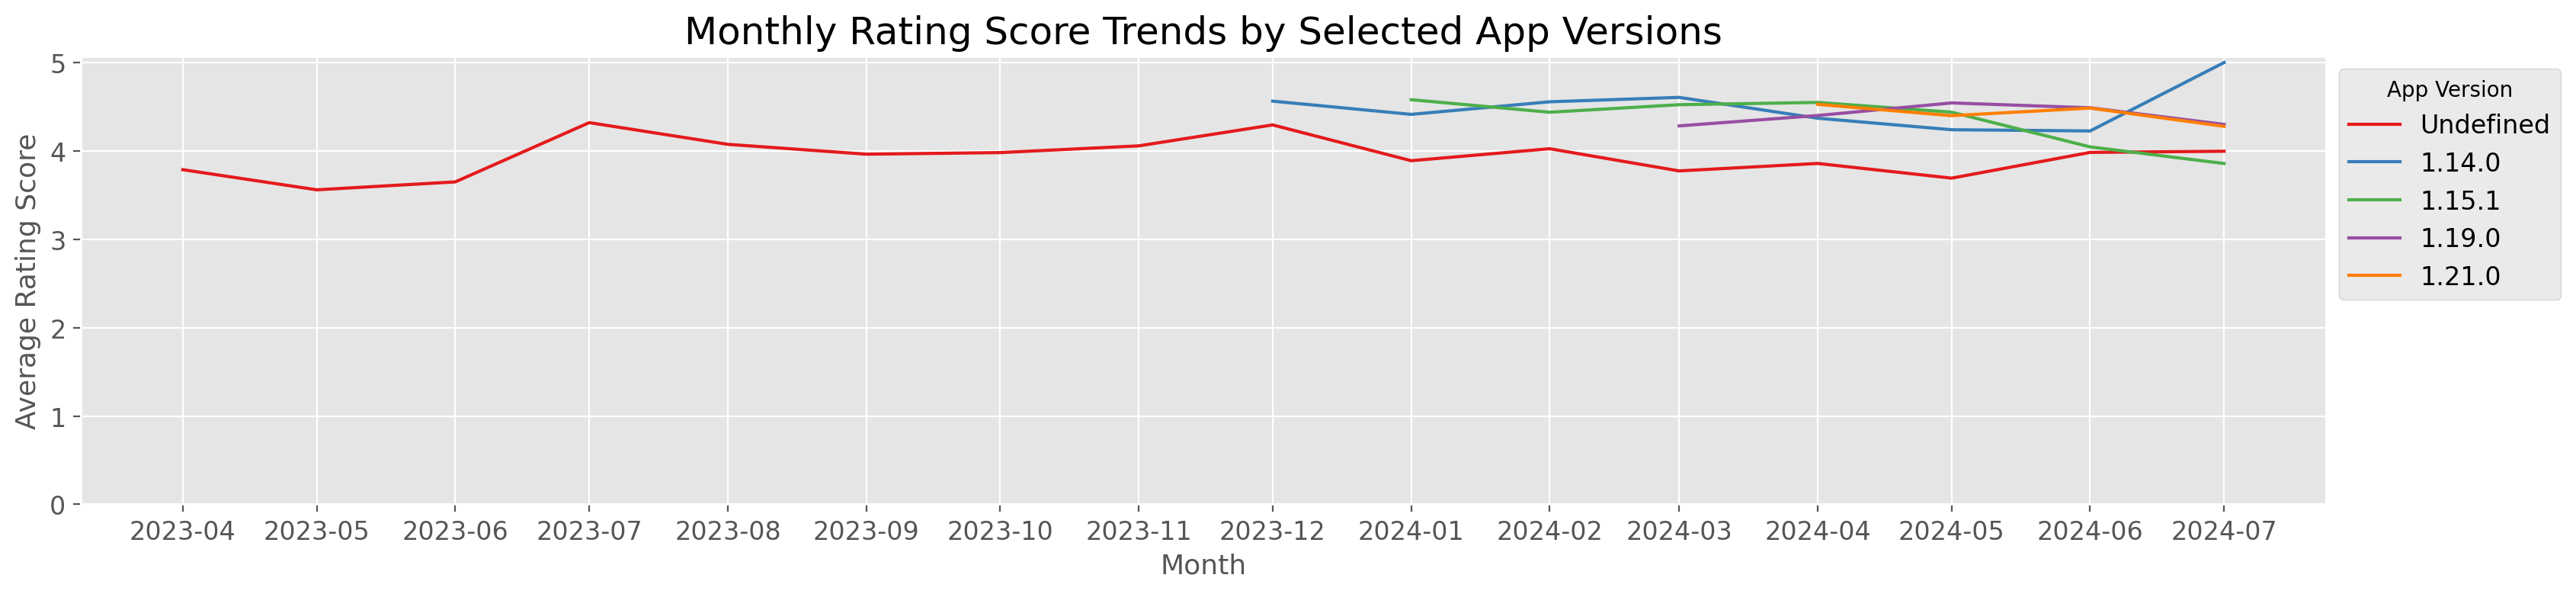

In [27]:
plt.figure(figsize=(17, 4), dpi=200)
sns.lineplot(data=monthly_trend, x='month_year', y='score', hue='reviewCreatedVersion', 
             palette='Set1')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('Monthly Rating Score Trends by Selected App Versions', size=18)
plt.xlabel('Month', size=13)
plt.ylabel('Average Rating Score', size=13)
plt.yticks(np.arange(0, 5.5, 1.0), size=12)
plt.xticks(rotation=0, ha='center', size=12)
plt.legend(title='App Version', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()

**Note**: Due to greater fluctuations in the previous line chart, representing day-to-day variations over two years, this line chart focuses more on the month-to-month variations of the top-five app versions, providing clearer temporal patterns. In general, the result here emphasizes the previous findings that the top-five app versions received good satisfaction scores. Specifically, the average rating scores of later versions in the top-five app versions are stable around 5.0. This might imply later versions succesfully fixed the bugs, leading constant user satisfaction over time.

### **3.3 Version Analysis**
While previous section already discussed app versions in relation to user satisfaction scores, the previous section only provided a glimpse information of the app versions. A further analysis needs to be carried out to evaluate in greater details to what extent users satisfied with the app according to different app versions.

#### **3.3.1 Which app version received low and high rating scores?**

In [30]:
# create crosstab to to count scores
scoreby_version = pd.crosstab(df4['reviewCreatedVersion'], df4['score'], margins=False)

# get percentage
score_percentage = scoreby_version.div(scoreby_version.sum(axis=1), axis=0) * 100

# display
score_percentage.style.background_gradient(cmap='YlOrRd').format('{:.2f}')

score,1,2,3,4,5
reviewCreatedVersion,,,,,
1.0.0,40.32,4.84,3.23,0.00,51.61
1.0.1,36.67,6.67,6.67,13.33,36.67
1.0.2,17.54,4.39,4.68,15.79,57.60
1.1.0,16.47,3.57,3.69,3.80,72.47
1.10.0,13.54,2.86,4.83,6.55,72.22
1.11.0,14.84,2.51,4.13,6.26,72.26
1.12.0,16.67,0.00,0.00,0.00,83.33
1.12.1,15.20,2.61,3.83,6.71,71.65
1.13.0,5.15,1.33,1.85,4.68,86.98


**Note**
- Overall, rating score 5 predominates satisfaction scores across the app versions. It is the rating score 5 which often received the majority values. Some versions, especially the earlier ones, indicate that the users are not satisfied enough, signaling the app has not met their expectations or fulfilled their needs. However, the lower satisfaction rate is normal since usually in earlier version, apps still have many bugs; product management and developer teams are still figuring out the app. 
- After releasing two versions, the satisfaction rate started to increase, possibly indicating major bug fixes by the devloper team, leading to more stable app and better user experience.

### **3.4 Content Analysis**
Content analysis will take a look at the length of the reviews (in words), frequent words, and frequent word combinations. The text length can indicate the variability of text length, providing an insight about whether the app users give lengthy or short reviews. And the frequent word and word combinations will shed light about the common patterns in word combinations, allowing a deeper analysis.

In addition to these three points, just a disclaimer, I have attempted to use language detection with `langdetect` but the output was not accurate enough and the process took more than five minutes. Many instances were detected as Tagalog (`tl`) instead of Indonesian (`id`). At glance, these inaccuracies are led by the short length so language detector performs poorly. Other possiblilty is the fact that the reviewers used informal variant of Indonesian which has not been sufficiently codified and trained on the language model. Given these inaccuracies, I will not use the feature. Column `language` was removed from the dataset.

#### **3.4.1 Are the review contents generally long or short?**

In [31]:
# extract review length
df4['review_len'] = df4['content'].str.split().str.len()

In [32]:
Q1 = df4['review_len'].quantile(0.25)
Q3 = df4['review_len'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df4.loc[(df4['review_len'] < lower_bound) | (df4['review_len'] > upper_bound)]
num_outliers = len(outliers)
total_rows = len(df4)

print(f"The number of outliers is {num_outliers} or {(num_outliers/total_rows*100):.2f}% of the total data ({total_rows} rows).")
display(outliers.sort_values(by='review_len', ascending=False).head())

The number of outliers is 9943 or 8.07% of the total data (123253 rows).


,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,month,year,review_len
75430,Pengguna Google,Stock Cheek Pad Dll Eps Sid Bluetooth: 1000 Ep...,2,0,Undefined,2024-01-25,1,2024,105
6495,Pengguna Google,"Gopay sejauh ini bgs, bs d blng luar biasa , c...",4,0,1.23.0,2024-06-22,6,2024,102
42344,Pengguna Google,"Gw gak tau duit gw bisa balik apa nggak , gw t...",1,1,1.19.0,2024-04-04,4,2024,96
3179,Pengguna Google,3 hari lalu sy top up saldo ovo via apk GoPay....,1,0,Undefined,2024-06-30,6,2024,93
55160,Pengguna Google,Mantap aplikasi anak bangsa .... Berharap gopa...,5,40,1.17.1,2024-03-09,3,2024,93


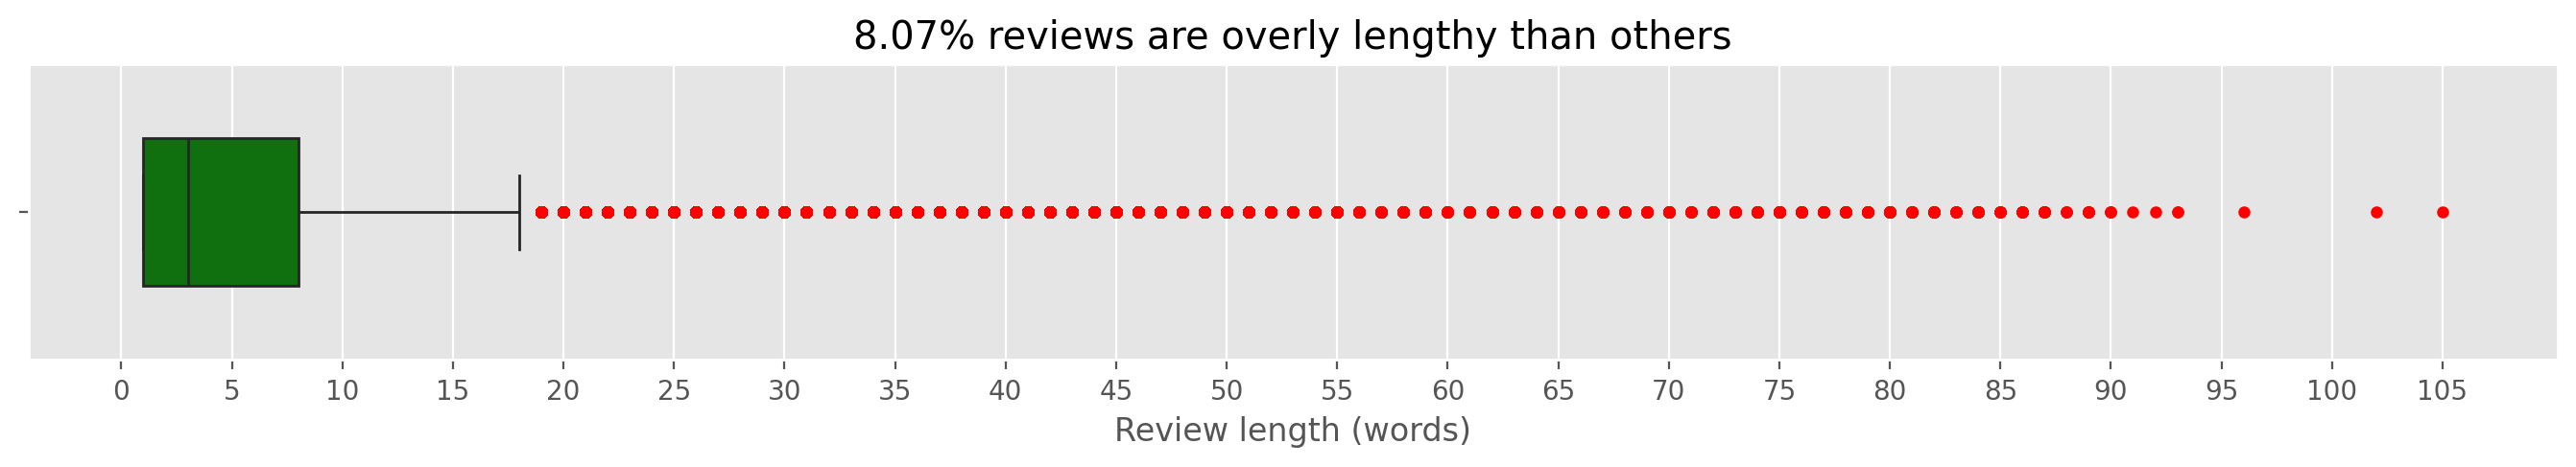

In [33]:
plt.figure(figsize=(17, 2), dpi=200)
sns.boxplot(x=df4['review_len'], color='green', width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1,
                            markersize=7))
plt.xticks(range(0, 110, 5))
plt.title(f'{(num_outliers/total_rows*100):.2f}% reviews are overly lengthy than others')
plt.xlabel('Review length (words)')
plt.show()

In [34]:
# retrieve reviews with len = 3
df4[df4['review_len'] == 3].head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,month,year,review_len
6,Pengguna Google,Mantap pakay gopay,5,0,1.24.1,2024-07-07,7,2024,3
7,Pengguna Google,mantap mantap mantap,5,0,1.24.1,2024-07-07,7,2024,3
20,Pengguna Google,Baik dan bersahabat,5,0,1.24.1,2024-07-07,7,2024,3
37,Pengguna Google,murah bagus berkualitas,5,0,1.24.1,2024-07-07,7,2024,3
46,Pengguna Google,Terbaik lah gobay,5,0,1.24.1,2024-07-07,7,2024,3


**Note**
- Overall, the review length tends to be short in which the median of the review length is 3 words such as *Mantap pakay gopay*, *mantap mantap mantap*, and *Baik dan bersahabat* with rating score 5. The high rating scores appearing here might be influenced by the majority of reviews with rating 5 (see Section 3.1).
- And as shown by the boxplot, 8.07% of the review lengths is outliers (red dots on the right side of the upper whisker). 
- However, since the boxplot above only shows the overall review length, it remains unclear whether specific rating scores will have specific tendency of review length. To obtain this insight, I will group the review lengths by rating scores.

In [61]:
# get desc stats for review len with score = 5
df4[df4['score'] == 5]['review_len'].describe().to_frame().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
review_len,94774.0,4.79,6.13,1.0,1.0,3.0,6.0,93.0


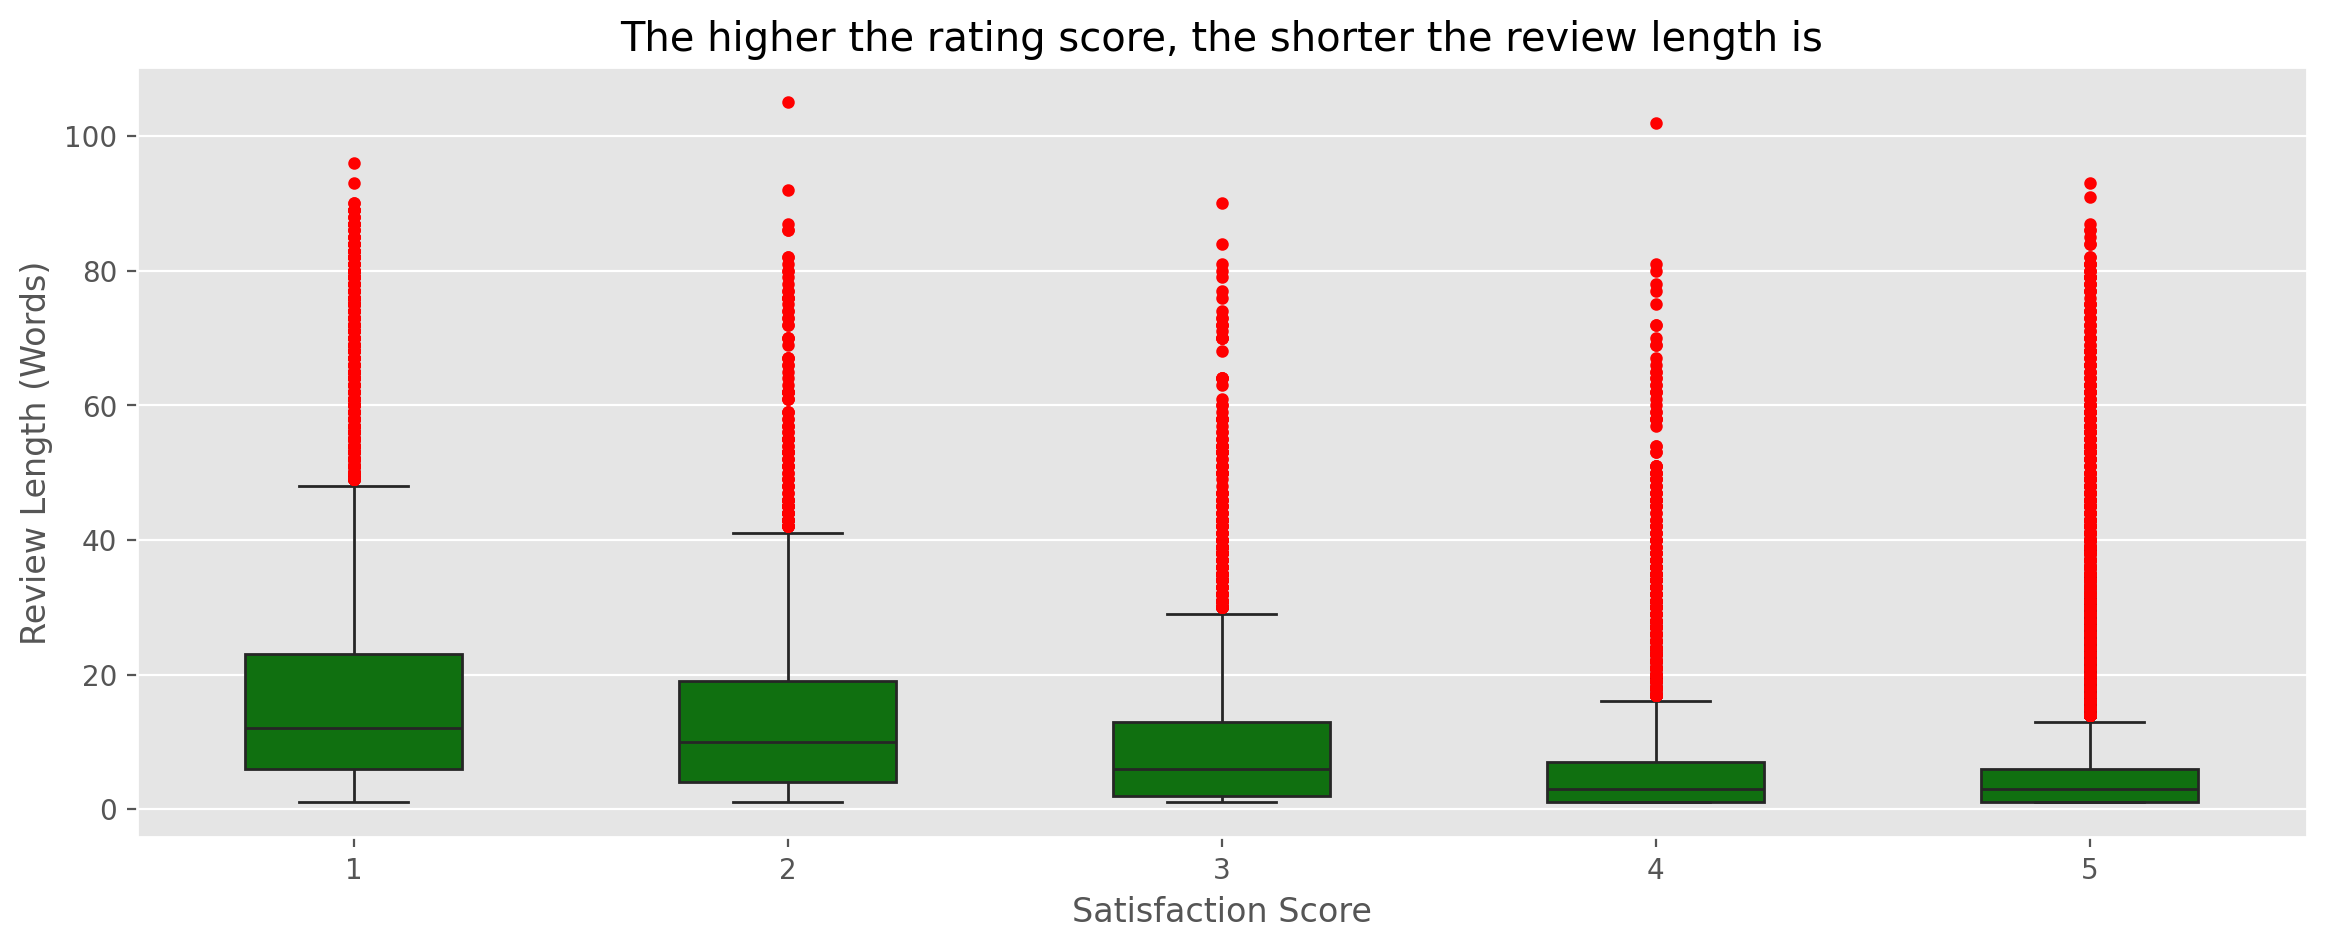

In [35]:
plt.figure(figsize=(14, 5), dpi=200)

sns.boxplot(x='score', y='review_len', data=df4, color='green', width=0.5, legend=False,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=7))

plt.title('The higher the rating score, the shorter the review length is')
plt.xlabel('Satisfaction Score')
plt.ylabel('Review Length (Words)')
plt.show()

In [36]:
# get num of reviews len per score
df4.groupby('score').agg({'review_len':'count'}).transpose()

score,1,2,3,4,5
review_len,13947,2758,4231,7543,94774


**Note**
- In general, the higher the rating score, the shorter the review length is. The review length is getting shorter as the rating score increases. This result might indicate that the more dissatisfied the app users, their reviews are more informative. And the more satisfied the user, their reviews tend to contain more words with positive sentiments. As previously shown, the median value of review length is 3 words, and they contain positive sentiment adjectives such as *mantap*, *bagus*, and *baik*.
- In addition, while the figure indicate narrower boxplot for rating score 5, the number of reviews are actually higher than the rest. And more importantly, the number is higher than the rating score 1, underscoring the previous findings that more users gave higher rating score to GoPay app.

#### **3.4.3 What are the most common words in the app reviews?**
Most common words are searched to identify what common or irrelevant words dominating the models, e.g., stop words

In [37]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh'}
stop_words.update(custom_stopwords)

# preprocess function
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '__num__', text)                          # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '__url__', text)               # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df4['tokens'] = df4['content'].apply(tokenize_text)

**Note**
- The set of stopwords in Indonesian is defined to filter out common words which lack or have no semantic content. They are mostly grammatical words (e.g., pronouns, verb *be*, and conjunctions) and some include discourse markers. For example, English has *well*, *I mean*, *right* while Indonesian people usually use *deh*, *nah*, *kok*, *sih*, *oh*. custom set of stopwords is also added since some discourse particles and enclitics are not yet included in NLTK.
- Negators such as *tidak*, *ga*, *gak*, or their informal variants were not added to the stop words since they are informative enough to indicate user pain points. Removing them will blur the frequent words or word combinations. For example, *tidak bagus* and *bagus* have separate meaning. The first adjective phrase highlights the negative perception due to the presence of the negator *tidak* whereas the second adjective phrase underscores the positive perception. Removing the negator may lead to misleading insights.
- Beside stop words, I have also preprocessed the review content (`content`) using `preprocess_text` function. This function cleaned the reviews from numbers, punctuation marks, URLs, and stop words that have been prepared previously. And as can be seen, numbers and URLs are not removed entirely but they are just converted to `__num__` to indicate their presence. The conversion was done because if the numbers remain in their original form (integers or floats), they will be considered as unique items by the model. And since they may only occur infrequently, they can be noise to the model.

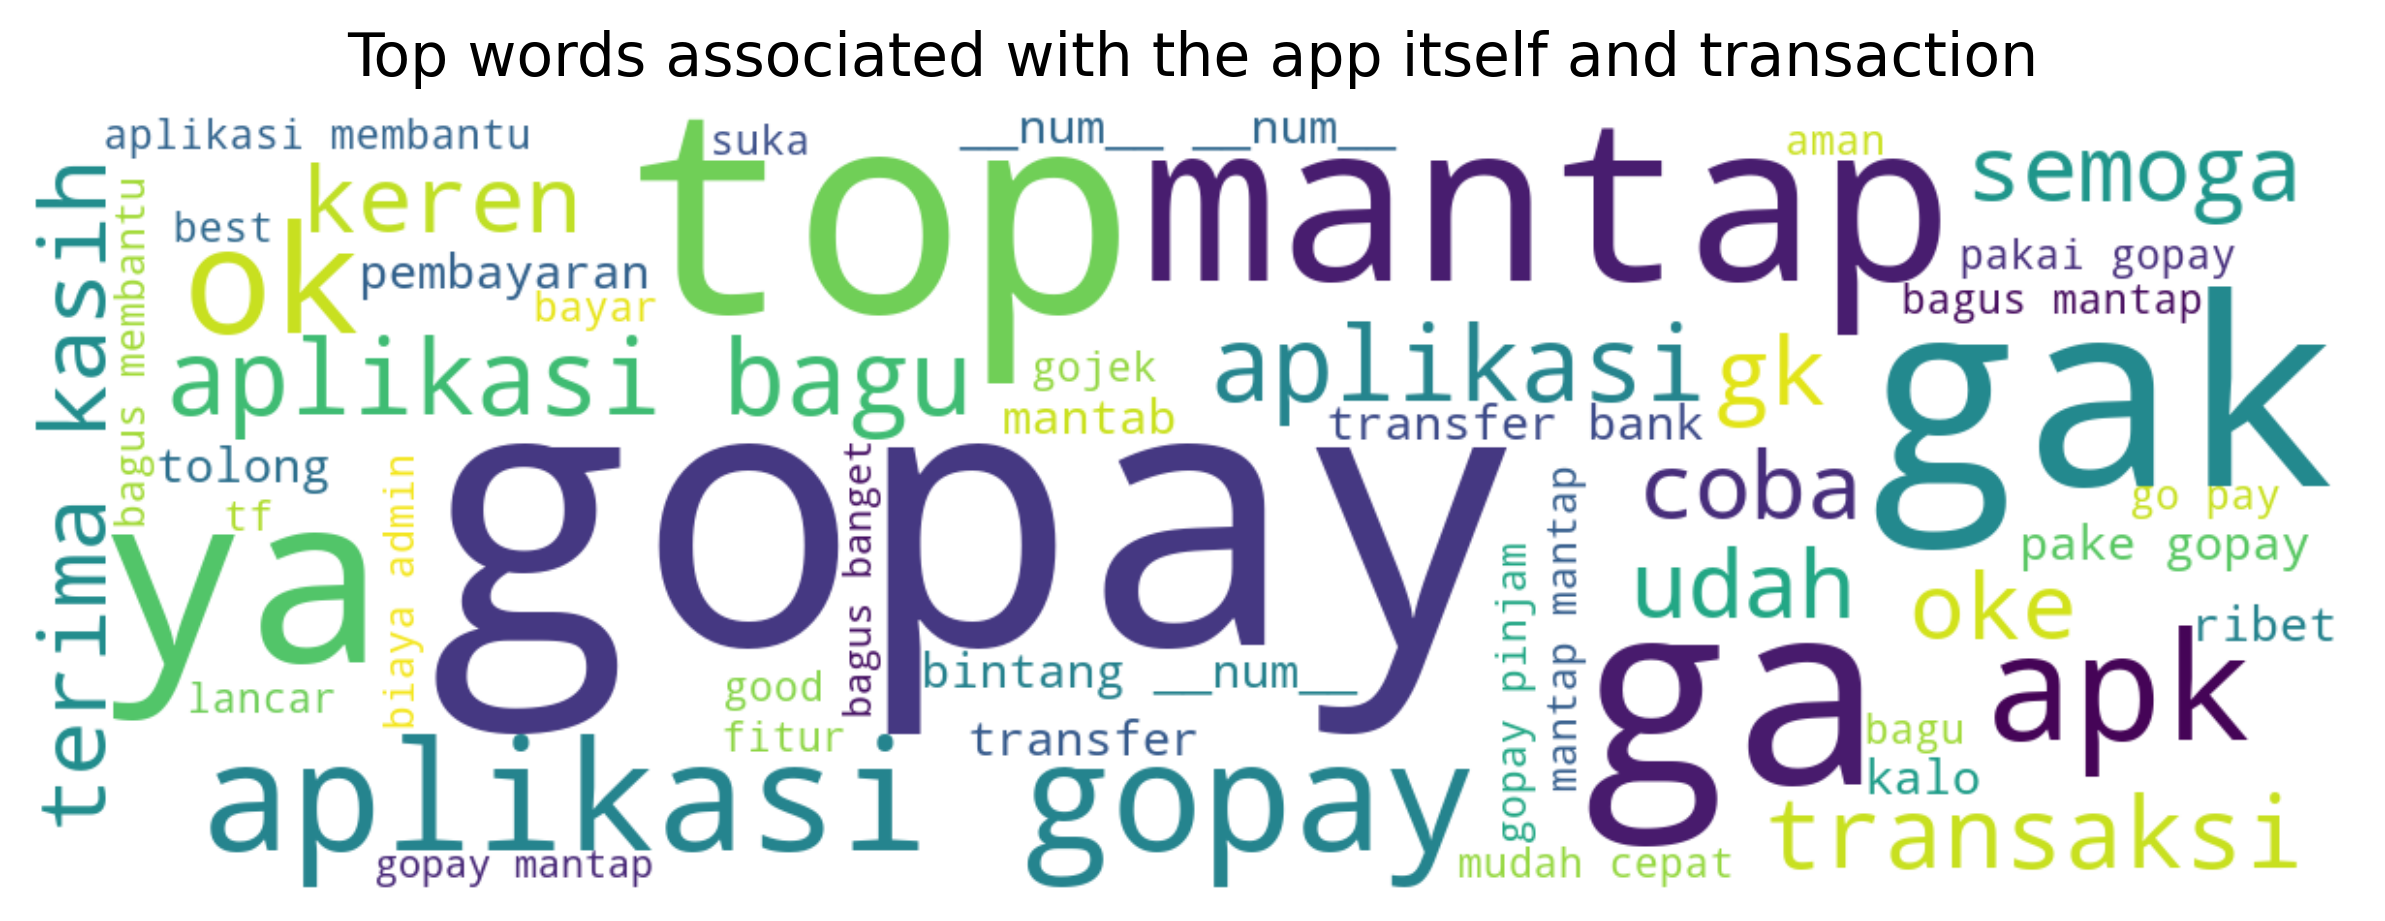

In [71]:
# flatten the list of tokens into a single string
all_tokens = ' '.join([' '.join([word for word in tokens if word not in stop_words]) for tokens in df4['tokens']])

# create the word cloud object
wordcloud = WordCloud(width=1200, height=400, background_color='white', max_words=50).generate(all_tokens)

# Plot the word cloud
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words associated with the app itself and transaction', y=1.02)
plt.axis('off')  
plt.show()

**Note**
- Based on the word cloud, the overall perception of users to the app is positive since the most frequent words appearing here (e.g., *terima kasih*, *mantap*, *bagus*) have positive connotations. 
- Some most frequent words also indicate service-related words (*transaksi*, *transfer*, and *pembayaran*) or expressions related to app itself (*gopay*, *apk*, and *aplikasi*). But to this point, it remains unknown whether these expressions are used in a positive manner since these words are isolated from their context. Below, I will investigate word combinations to see whether there are some patterns, indicating user experience or pain points but since the most dominant rating scores are 1 and 5, I will focus more on these rating scores. 

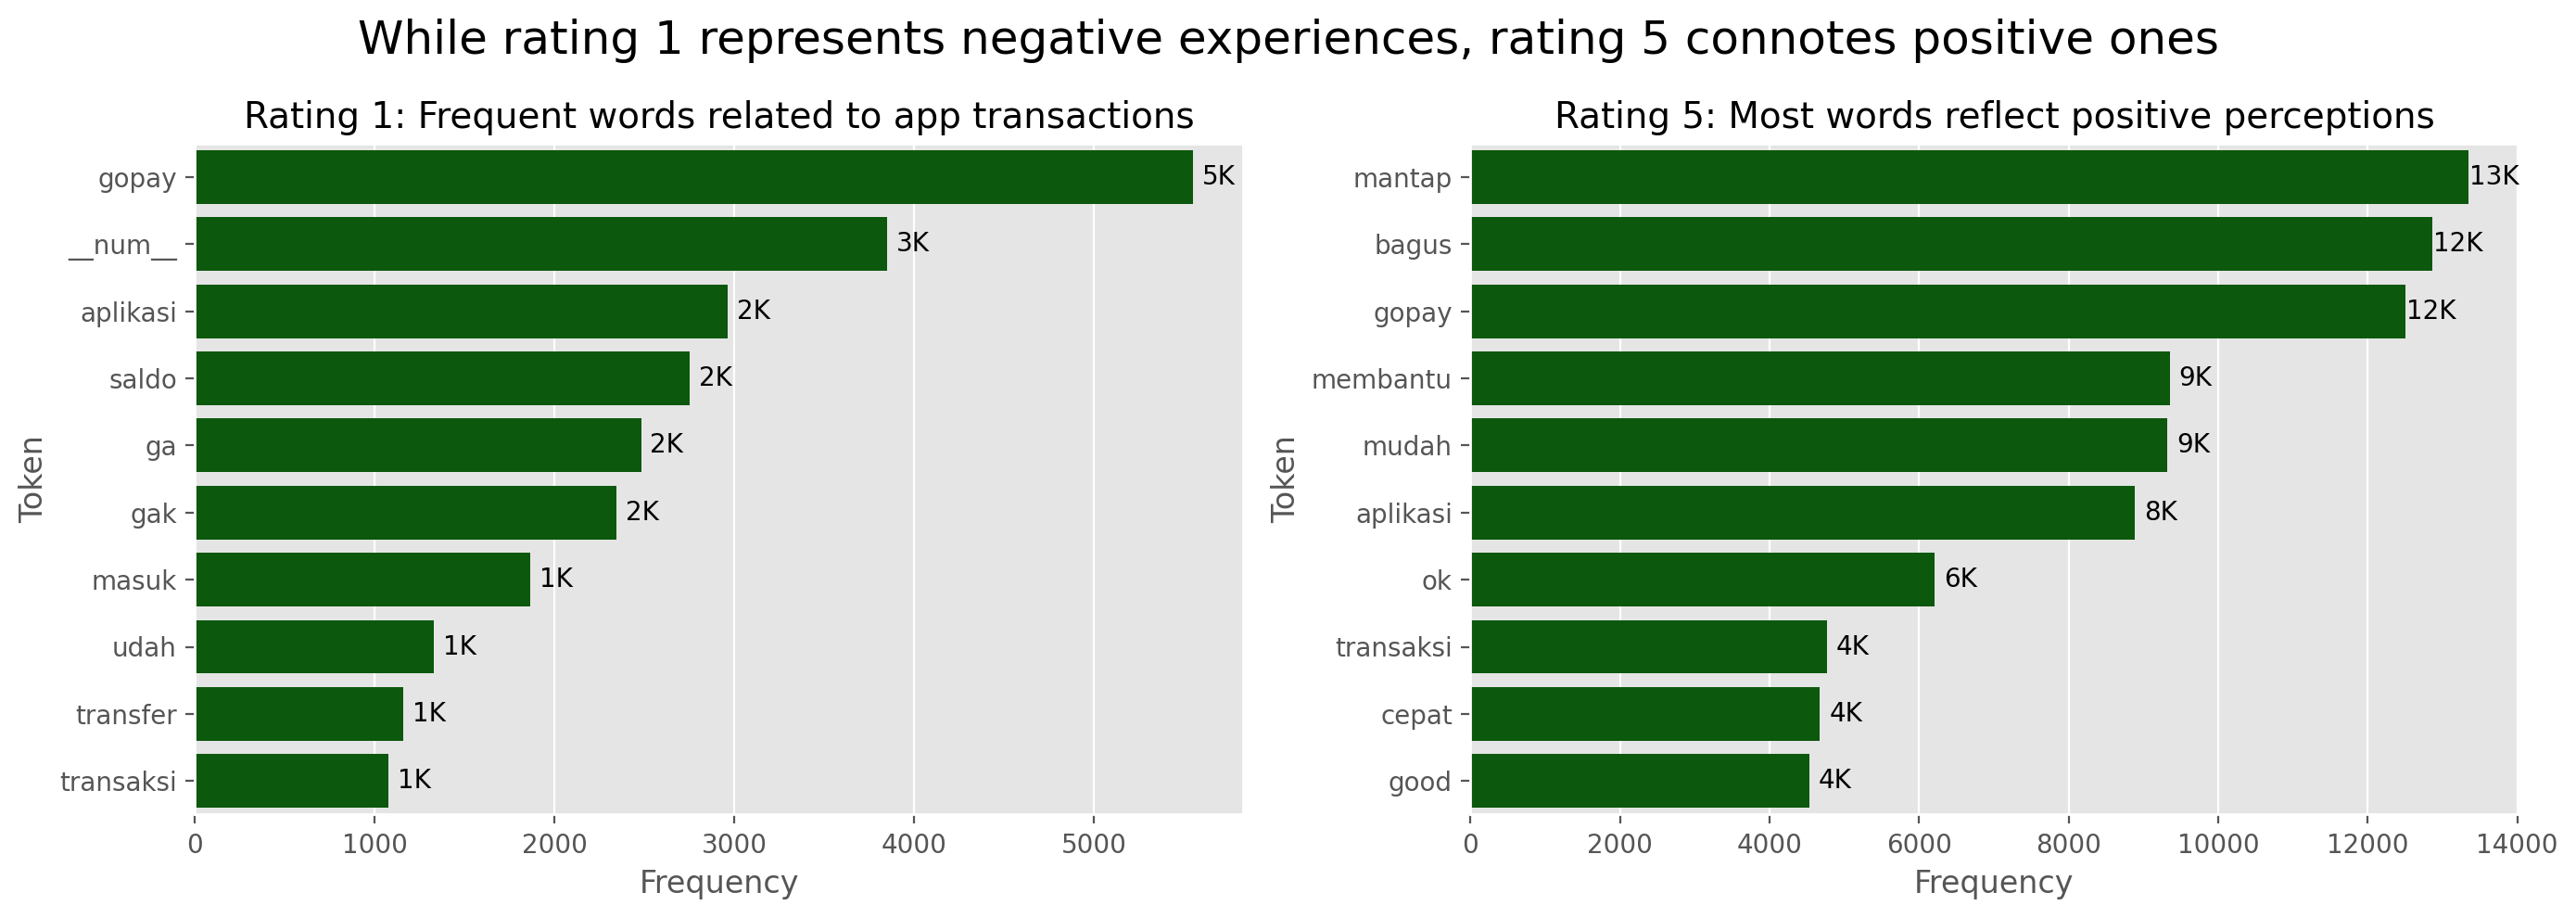

In [39]:
# create subplots: two columns side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), dpi=200)

# plot 1: Most frequent tokens for score 1 (on the left)
all_tokens = [token for sublist in df4[df4['score'] == 1]['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='darkgreen', ax=axes[0])
axes[0].set_title('Rating 1: Frequent words related to app transactions', fontsize=14)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Token', fontsize=12)
for p in axes[0].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[0].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

# Plot 2: Most frequent tokens for score 5 (on the right)
all_tokens = [token for sublist in df4[df4['score'] == 5]['tokens'] for token in sublist]
token_counts = Counter(all_tokens)
token_df = (pd.DataFrame(token_counts.items(), columns=['token', 'count'])
            .sort_values(by='count', ascending=False))

sns.barplot(x='count', y='token', data=token_df.head(10), color='darkgreen', ax=axes[1])
axes[1].set_title('Rating 5: Most words reflect positive perceptions', fontsize=14)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Token', fontsize=12)
for p in axes[1].patches:
    count_value = int(p.get_width())
    label = f'{count_value // 1000}K' if count_value >= 1000 else str(count_value)
    axes[1].annotate(label,
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0),
                     textcoords='offset points', fontsize=10)

plt.suptitle('While rating 1 represents negative experiences, rating 5 connotes positive ones', 
             size=18)
plt.tight_layout()
plt.show()

**Note**
- Above I specified the most frequent words in the review contents, specifying rating score 1 and 5. In general, review contents in rating 1 and 5 reveal different patterns in which rating score 1 tends to highlight service-related words, particularly transactions, such as *transaksi* and *transfer*, along with the Indonesian negation (*ga* and *gak*) and verb *masuk* potentially indicating user pain points and rooms for improvements.
- Reviews with rating score 5, on the other hand, reveal the positive sides or the strengths of the app using words such as *good*, *cepat*, *bagus*, *membantu*, and *mantap*.
- In brief, these results are expected. Reviews with rating score 1 are expected to show the user pain points or rooms for improvements whereas those with rating score 5 should inform about the strengths of the app.

#### **3.4.4 What are the most frequent phrases in the reviews?**
Due to the high volume of text data, getting most frequent phrases in the app reviews using bigram and trigram cannot be done. The large data size is unable to process using my local machine. For this reason, I will focus more on user reviews containing "gopay" with one and five rating stars by subsetting the dataset.

In [40]:
# subset rating score 1 and 5
score1 = df4[(df4['score'] == 1) & (df4['content'].str.contains('gopay'))]
score5 = df4[(df4['score'] == 5) & (df4['content'].str.contains('gopay'))]

##### **3.4.4.1 Most Frequent Phrases in Score Rating 1**

In [41]:
# initialize CountVectorizer for n-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b')
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b')
bigram_X = bigram_vectorizer.fit_transform(score1['content'])
trigram_X = trigram_vectorizer.fit_transform(score1['content'])

# get n-gram counts
bigram_counts = bigram_X.toarray().sum(axis=0)
trigram_counts = trigram_X.toarray().sum(axis=0)
bigram_names = bigram_vectorizer.get_feature_names_out()
trigram_names = trigram_vectorizer.get_feature_names_out()

# dfs for n-grams and their counts
bigram_df = pd.DataFrame({'ngram': bigram_names, 'count': bigram_counts})
bigram_df = bigram_df[bigram_df['count'] > 0].sort_values(by='count', ascending=False)
trigram_df = pd.DataFrame({'ngram': trigram_names, 'count': trigram_counts})
trigram_df = trigram_df[trigram_df['count'] > 0].sort_values(by='count', ascending=False)

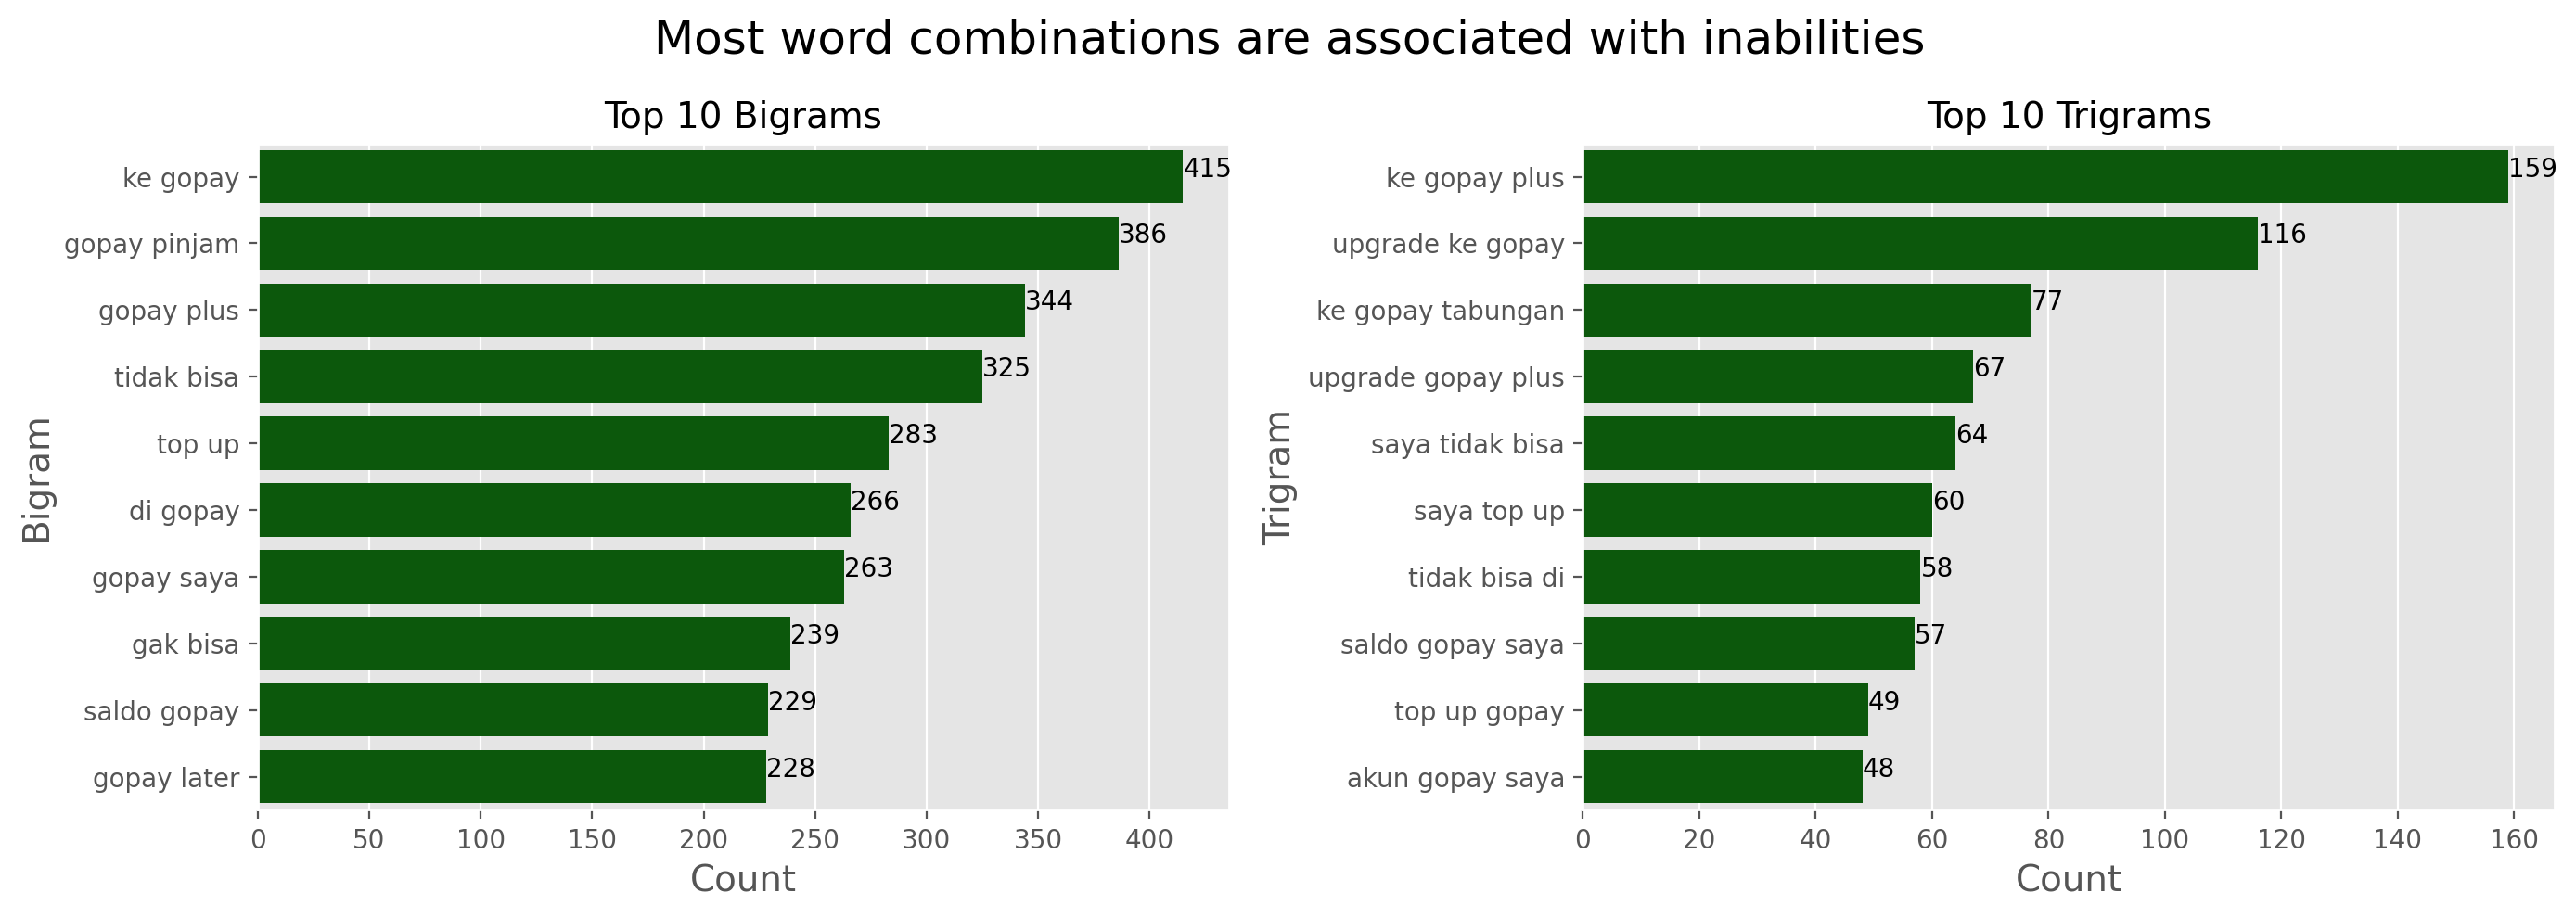

In [42]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# plot for bigrams
sns.barplot(x='count', y='ngram', data=bigram_df.head(10),
            ax=axes[0], color='darkgreen')
for index, value in enumerate(bigram_df.head(10)['count']):
    axes[0].text(value, index, str(value))
axes[0].set_title('Top 10 Bigrams', fontsize=14)
axes[0].set_xlabel('Count', fontsize=14)
axes[0].set_ylabel('Bigram', fontsize=14)

# plot for trigrams
sns.barplot(x='count', y='ngram', data=trigram_df.head(10),
            ax=axes[1], color='darkgreen')
for index, value in enumerate(trigram_df.head(10)['count']):
    axes[1].text(value, index, str(value))
axes[1].set_title('Top 10 Trigrams', fontsize=14)
axes[1].set_xlabel('Count', fontsize=14)
axes[1].set_ylabel('Trigram', fontsize=14)
plt.suptitle('Most word combinations are associated with inabilities',
             size=18)
plt.tight_layout()
plt.show()

**Note**: As the word combinations were filtered by instances containing *gopay*, it makes sense that many bigrams and trigrams here contain *gopay*. The focus on *gopay* here indicates user undesirable experiences directly with the app explicitly. As can be seen, the most frequent word combinations are associated with the service *gopay plus* both in bigrams and trigrams. And in both bar charts, the general patterns is users' inability to use the app service properly, indicated by *gak bisa*, *tidak bisa*, *upgrade ke gopay*, *saya top up*. This insight help us narrow down the user pain points to *gak bisa* and *saya tidak bisa* since these bigram and trigram are widespread in reviews with rating score 1. 

In [43]:
# filter and sample
pd.options.display.max_colwidth = 200
(df4[(df4['score'] == 1) & 
     (df4['content'].str.contains(r'(?:tidak|ga) bisa', regex=True))]
 .sample(n=5, random_state=42)).loc[:, ['userName', 'content', 'score']]

,userName,content,score
64188,Pengguna Google,Saya kirim uang dari dana ke gopay tidak bisa masuk,1
14637,Pengguna Google,Kenapa saya tidak bisa tf padahal saldo masih ada,1
90455,Pengguna Google,Saldo saya tidak bisa di tarik,1
100134,Pengguna Google,"Kecewa dengan apk ini, tidak bisa top up driver lagi",1
102448,Pengguna Google,"Halo Admin, Saya ingin mengeluh atas Gopaylaternya. Pada Device saya terjadi error dalam membayar gopaylater tetapi karna error tsb saya tidak bisa menggunakan gopay later maupun gopay pinjam lagi...",1


**Note**: The five samples drawn from the dataset with keyword *tidak bisa* and rating score 1 highlights users' inabilities to use the services in the app such as unable to sign up, unable to make transactions, unable to use the pay later service. But since these are only random samples, it is necessary to reval the patterns of *tidak bisa* phrase usage. The patterns can be drawn by exploiting bigrams to look for words after the phrase.

In [44]:
# preprocess function to clean text
def clean_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '__url__', text)      # remove URLs
        text = re.sub(r'\d+', '__num__', text)                          # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'\s+', ' ', text)                                # replace multiple spaces with a single space
        return text.strip()                                             # return cleaned text
    return ''

# clean the content column
df4['cleaned_content'] = df4['content'].apply(clean_text)

In [45]:
# create list store texts
all_text = ' '.join(df4['cleaned_content'].tolist())

# tokenize into words
tokens = all_text.split()

# find co-occurrences with "gopay plus"
co_occurrences = []
for i in range(len(tokens) - 1):
    if (tokens[i] == "tidak" and tokens[i + 1] == "bisa") or (tokens[i] == "gak" and tokens[i + 1] == "bisa"):
        # look at words after the phrase
        if i + 2 < len(tokens) and tokens[i + 2] not in stop_words:  
            co_occurrences.append(tokens[i + 2])  

# count the frequency 
co_occurrence_counts = Counter(co_occurrences)

In [46]:
# convert to df for visualization
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['Word', 'Frequency'])
co_occurrence_df = co_occurrence_df.sort_values(by='Frequency', ascending=False)

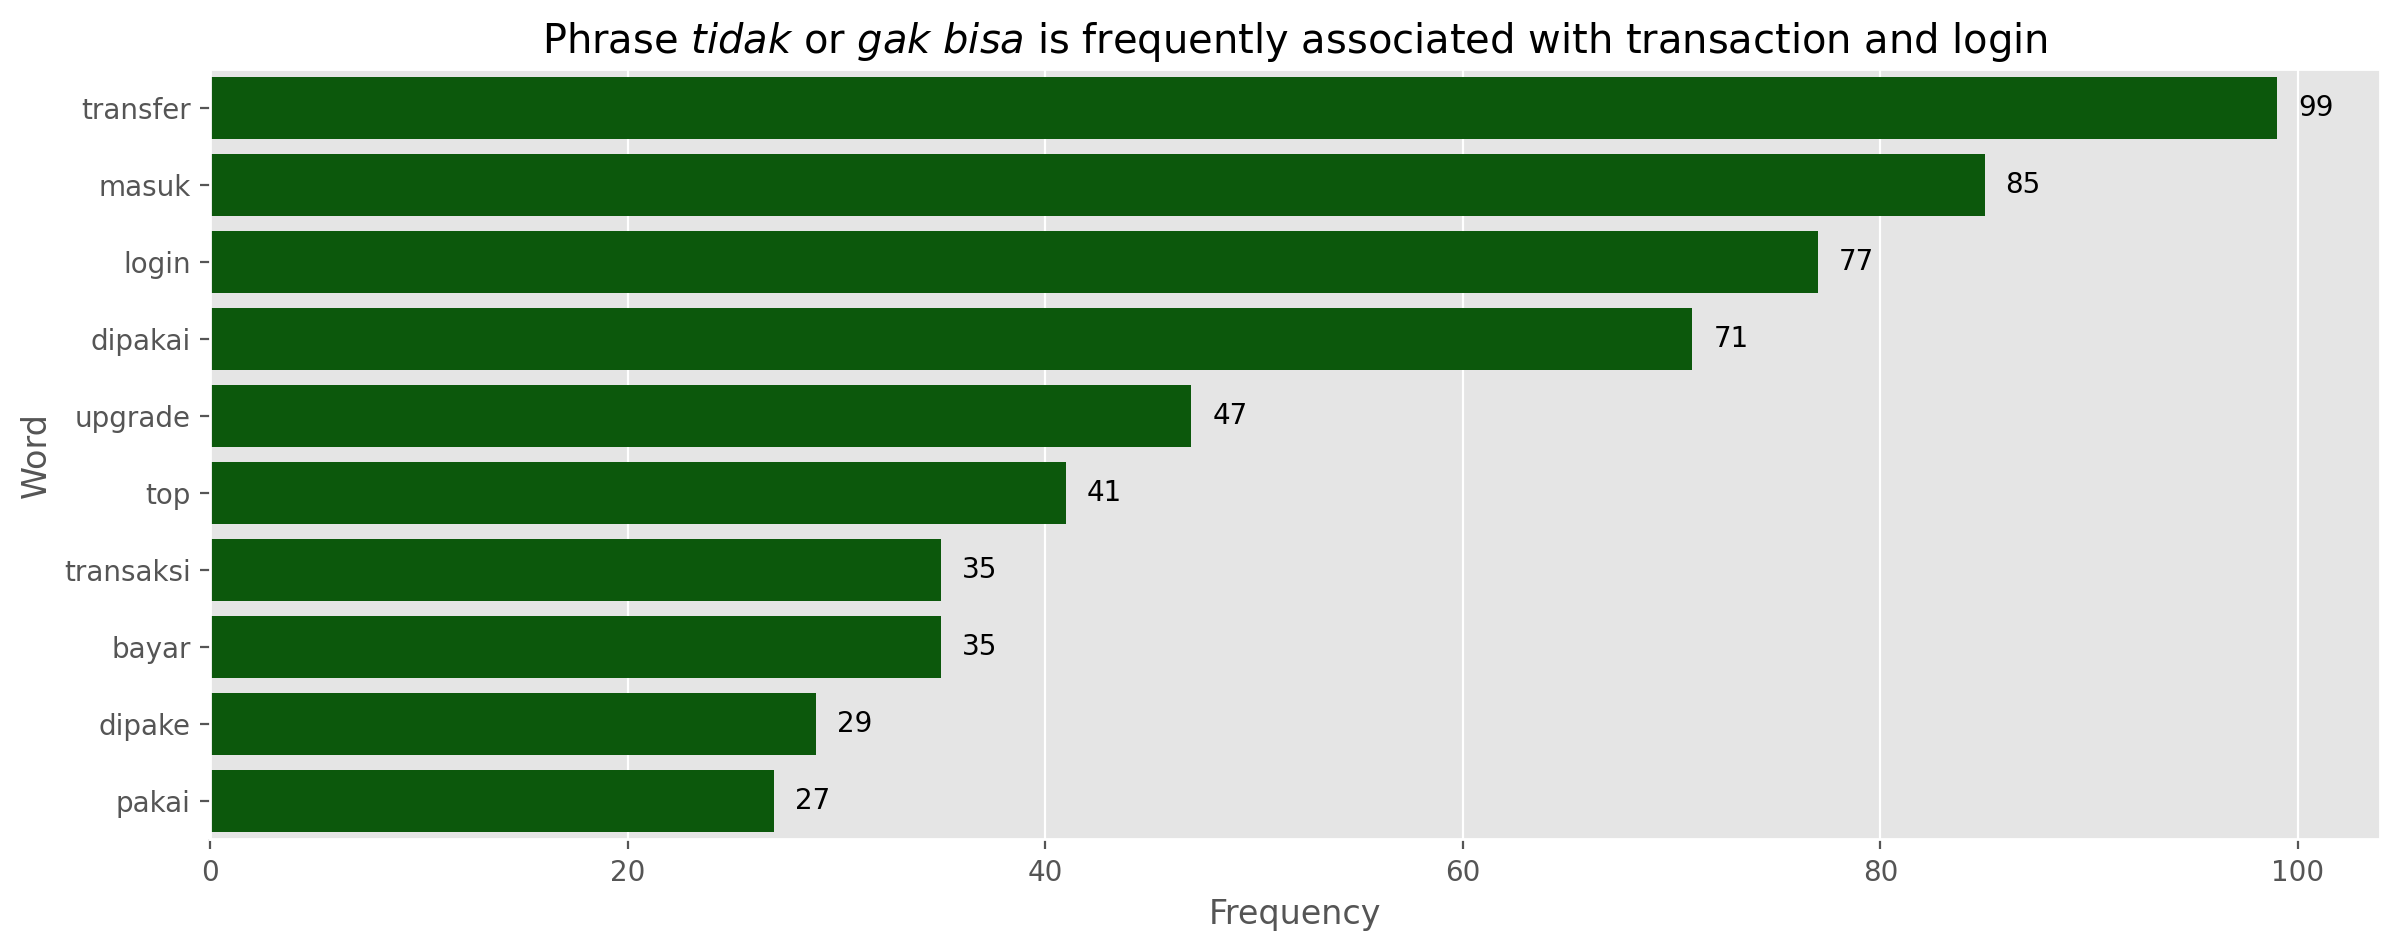

In [47]:
plt.figure(figsize=(14, 5), dpi=200)
sns.barplot(x='Frequency', y='Word', data=co_occurrence_df.head(10), legend=False, color='darkgreen')
for index, value in enumerate(co_occurrence_df['Frequency'].head(10)):
    plt.text(value + 1, index, str(value), va='center')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Phrase $tidak$ or $gak$ $bisa$ is frequently associated with transaction and login')
plt.show()

**Note**: Previously, I found out that word combinations related to inabilies of using the app (*tidak bisa* and *ga bisa*) are among the most prevalent phrases. Above, I searched words frequently co-occur with the phrases. The plot highlights the inabilities are closely related to transaction making in the app and login to the app. The word *transfer*, *top*, *transaksi*, and *bayar* often come up after the phrase *tidak* or *gak bisa*. To this point, the result have specified the rooms for improvement in the app, particularly related to app login and transaction making. Nonetheless, whether this problem should be prioritized by the product team and the developer team remains an open question here. To answer this question, not only can we consider the occurrences of the reviews (already discovered) but also the number of thumbs up count, potentially representing the number of users experiencing the same issues.

In [48]:
# count thumbsup associated with the inability phrases
inability_df = df4[(df4['score'] == 1) & (df4['content'].str.contains(r'(?:tidak|ga) bisa', regex=True))]
(inability_df.sort_values(by='thumbsUpCount', ascending=False)
 .loc[:, ['thumbsUpCount', 'content']]
 .head(10)
 .style.background_gradient(subset=['thumbsUpCount'], cmap='YlOrRd'))

,thumbsUpCount,content
62888,423,"Sebelumnya sangat nyaman pake gopay, entah kenapa akhir2 ini sering error aplikasinya Bintang 1 dulu ... kalau sudah ada perbaikan, dijamin bintang 5 - Top up saldo lambat, biasanya hitungan detik sudah masuk - Rekening bank sering maintenance - isi pulsa pernah ga masuk, dan no solusi - akun tiba2 terblokir tanpa alasan jelas dan tanpa solusi Semoga bisa berbenah, terima kasih"
92099,215,Suruh upgrade ke gopayplus..tp ambil foto ktp aja susahnya minta ampuuuunnn..malah balik ke awal lagi..😓😓 Beberapa kali nyoba upgrade..mau foto e-ktp tetep ga bisa..balik lagi terus ke tampilan awal..ngapain nyuruh upgrade klo ga bisa..!!
49625,207,"fitur tarik tunai nya ga jelas, padahal jaringan stabil dan sudah upgrade ke gopay plus, saldo saya juga jadi ga bisa ke pake krn nge stuck lagi di proses. Padahal udah nunggu dari semalaman tapi tetep ga dibalikin saldo nya, bad banget lah, ga lagi pke jasa gopay."
71335,178,"Mau bayar dan beli tagihan gopay tidak bisa digunakan tanpa alasan yang jelas , sudah laporin dan sudah di tanggapi , tapi masalah tetap 5ak terselesaikan , sampai sekarang akun saya masih tidak bisa membayar tagihan ataupun membeli token atau pulsa. Sangat mengecewakan"
55521,177,"Gopaylater makin lama makin gak jelas, awal awal dikasih limit bisa dipakai lancar pembayaran pun lancar, udah 1 bulan tidak bisa dipakai dengan alasan masih ada tagihan/ akun tidak memenuhi kualitas kredit, la sekarang ada pemberitahuan penaikan limit, tapi masih tetap saja diblokir, ngapain dikasih limit dan dikasih kenaikan tapi tidak bisa dipakai, tutup aja min"
36166,157,"Sangat kecewa pada aplikasi gopay, akun sdh gopay plus tiba2 balik ke basic, mau upgarde lagi tidak bisa, dengan alasan data ektp tdk sesuai dgn dukcapil, sdh email pernyataan dari dukcapil klo data sesuai tetep tdk bisa krn warna rambut di foto ektp dan foto selfie berbeda, tolong dunk jgn terlalu dibikin ribet, yg pentingkan orangnya sama... Di bank aja tdk seribet ini 🙈🤣👎"
6848,151,Aplikasi sangat BURUK. Percuma ngasih limit besar pernah pakai juga tidak pernah telat bayar tagihan. Udah mau 2 bulan ini paylaternya tidak bisa digunakan dengan alasan analisis penyedia layanan gopaylater. Telp CS jawaban bertele tele . PERCUMA
30881,137,"Tolong jangan ada yg pake aplikasi ini lagi ya, karna benar2 jelek, ga guna, saya komplain respon nya malah salahin BCA karna katanya ada gangguan, pas saya email BCA nya ternyata ga ada gangguan sama sekali, cs tidak memberikan solusi sama sekali, sudah 3 hari saya tidak bisa transaksi pake gopay, gausa salahin sinyal ya, saya udh pake kuota+wifi pun tetap sama. Cs bego."
29558,136,"Awal-awal make sih bagus, eeeh... Itu percuma juga setiap transaksi mendapatkan coins, tapi faktanya coins tidak bisa untuk transaksi pembelian, padahal katanya secara otomatis bisa untuk pembayaran setelah mengatifkan toggle., Omon -omon doang gopay..."
29828,120,Aplikasi pertam bagus dan banyak promo. Semakin kesini aplikasi yang tidak layak didownload. Banyak kesalahan mulai dari gopay later sampai promo... Tim yang menjawab seperti robot tidak bisa dicerna dan muter muter


**Note**: The dataframe above lists 1-rating score reviews containing phrase *tidak bisa* or *gak bisa*. The darker the color of column `thumbsUpCount`, the higher the thumbs up count is. In general, the first row has the largest number of thumbs up. In this record, the user complained about the frequent unpleasant experiences with the app such as slow top up process, frequent banking service maintenance, and blocked account. This review has been upvoted or given thumbs up by other users for more than 400 times. This number of thumbs up is an indicative of similar unpleasant experiences happening to other users, underscoring the higher priority of resolving the problem.

In [49]:
# prepare data
inability_veersion_df = (inability_df.groupby('reviewCreatedVersion')
                         .size()
                         .reset_index(name='count')
                         .nlargest(n=5, columns='count'))

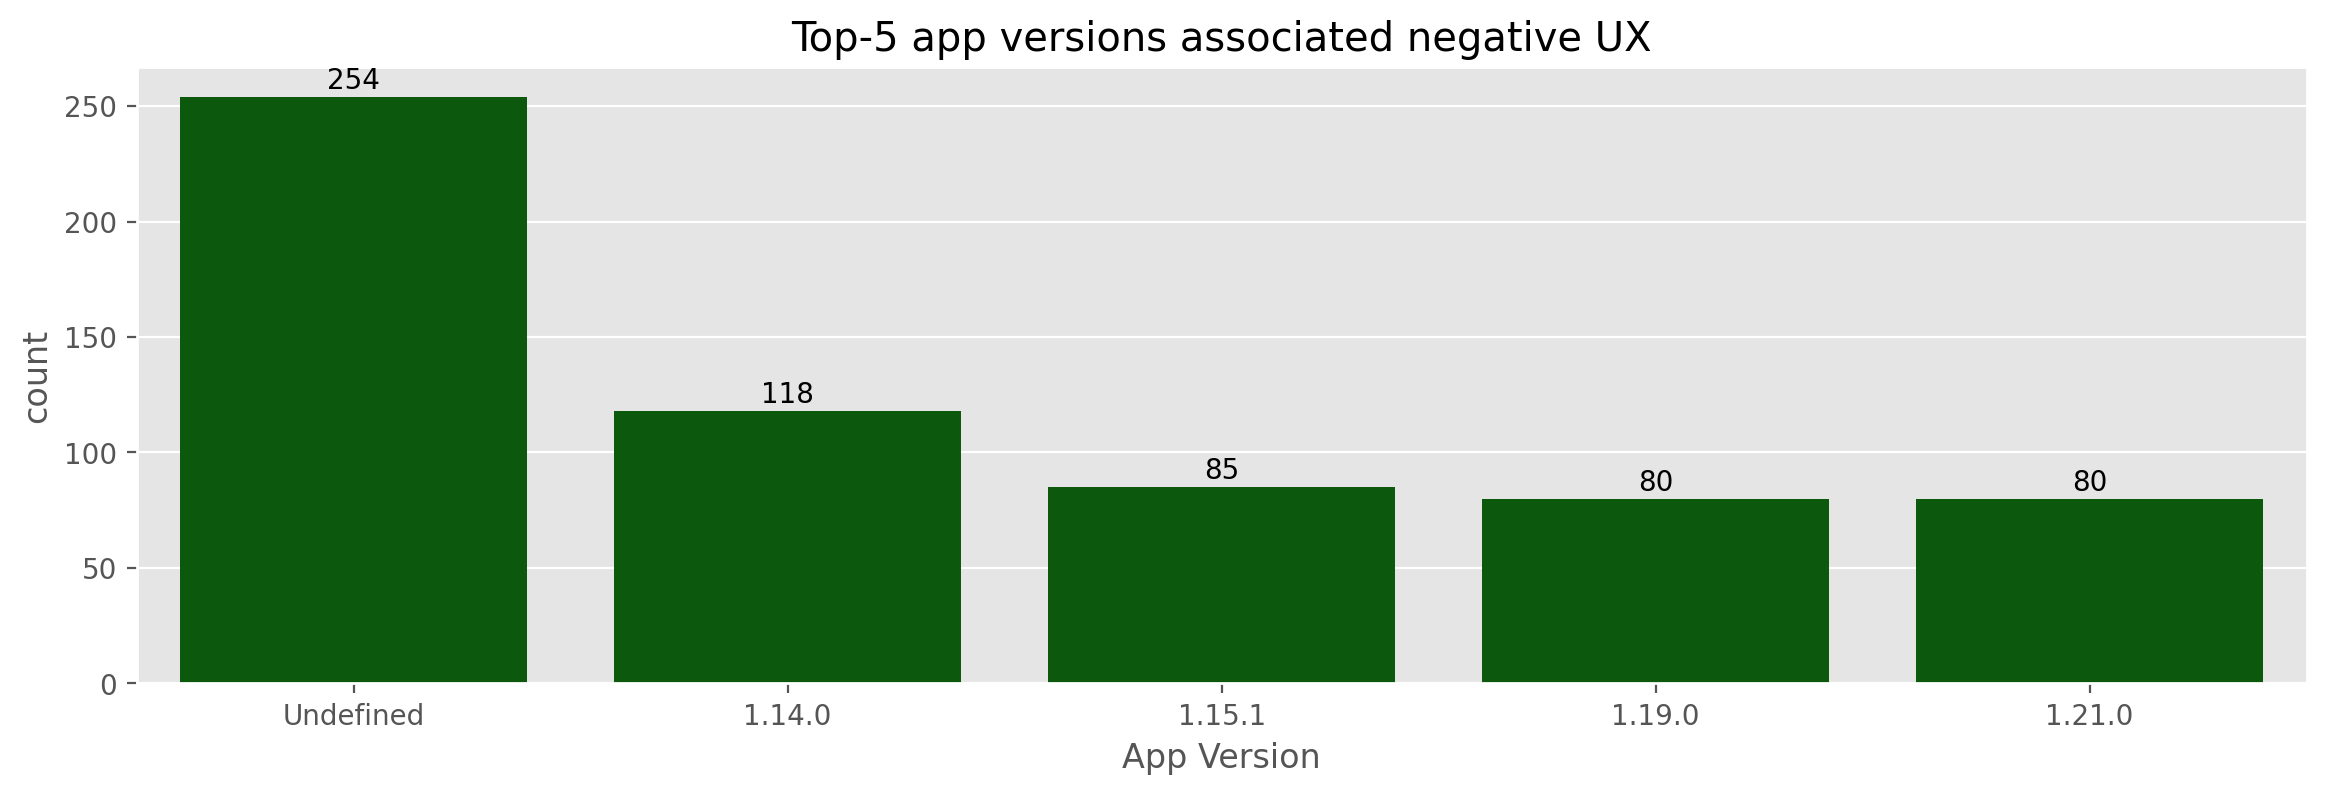

In [50]:
plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(y='count', x='reviewCreatedVersion', data=inability_veersion_df, legend=False, color='darkgreen')
for index, value in enumerate(inability_veersion_df['count']):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)
plt.title('Top-5 app versions associated negative UX')
plt.xlabel('App Version')
plt.show()

**Note**: The bar chart summarizes app versions associated with negative user experience. In short, undefined version has the highest frequency of records associated with the unpleasant UX but due to its non-clarity, version 1.14.0 becomes the top priority app requiring immediate attention by the product and developer team.

##### **3.4.4.1 Most Frequent Phrases in Score Rating 5**
In the previous section, I have revealed that as expected, reviews with 1-rating scores, tend to contain negative user experiences with the app, indicating opportunities for making improvements. After narrowing down to top words and word combinations (2-grams and 3-grams), it was found that the negative user experiences are related to problems with transaction making and app login. The problems are frequently found in the earlier versions of the app, particularly app version 1.14.0. Considering the number of thumbs up to reviews associated with transaction and login issues, an immediate action should be taken to address the user pain points. 

In this section, my aim is to investigate the content of reviews with 5-rating scores by examining top word combinations to understand potential strengths of the app.

In [51]:
# initialize CountVectorizer for n-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b')
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b')
bigram_X = bigram_vectorizer.fit_transform(score5['content'])
trigram_X = trigram_vectorizer.fit_transform(score5['content'])

# get n-gram counts
bigram_counts = bigram_X.toarray().sum(axis=0)
trigram_counts = trigram_X.toarray().sum(axis=0)
bigram_names = bigram_vectorizer.get_feature_names_out()
trigram_names = trigram_vectorizer.get_feature_names_out()

# # dfs for n-grams and their counts
bigram_df = pd.DataFrame({'ngram': bigram_names, 'count': bigram_counts})
bigram_df = bigram_df[bigram_df['count'] > 0].sort_values(by='count', ascending=False)
trigram_df = pd.DataFrame({'ngram': trigram_names, 'count': trigram_counts})
trigram_df = trigram_df[trigram_df['count'] > 0].sort_values(by='count', ascending=False)

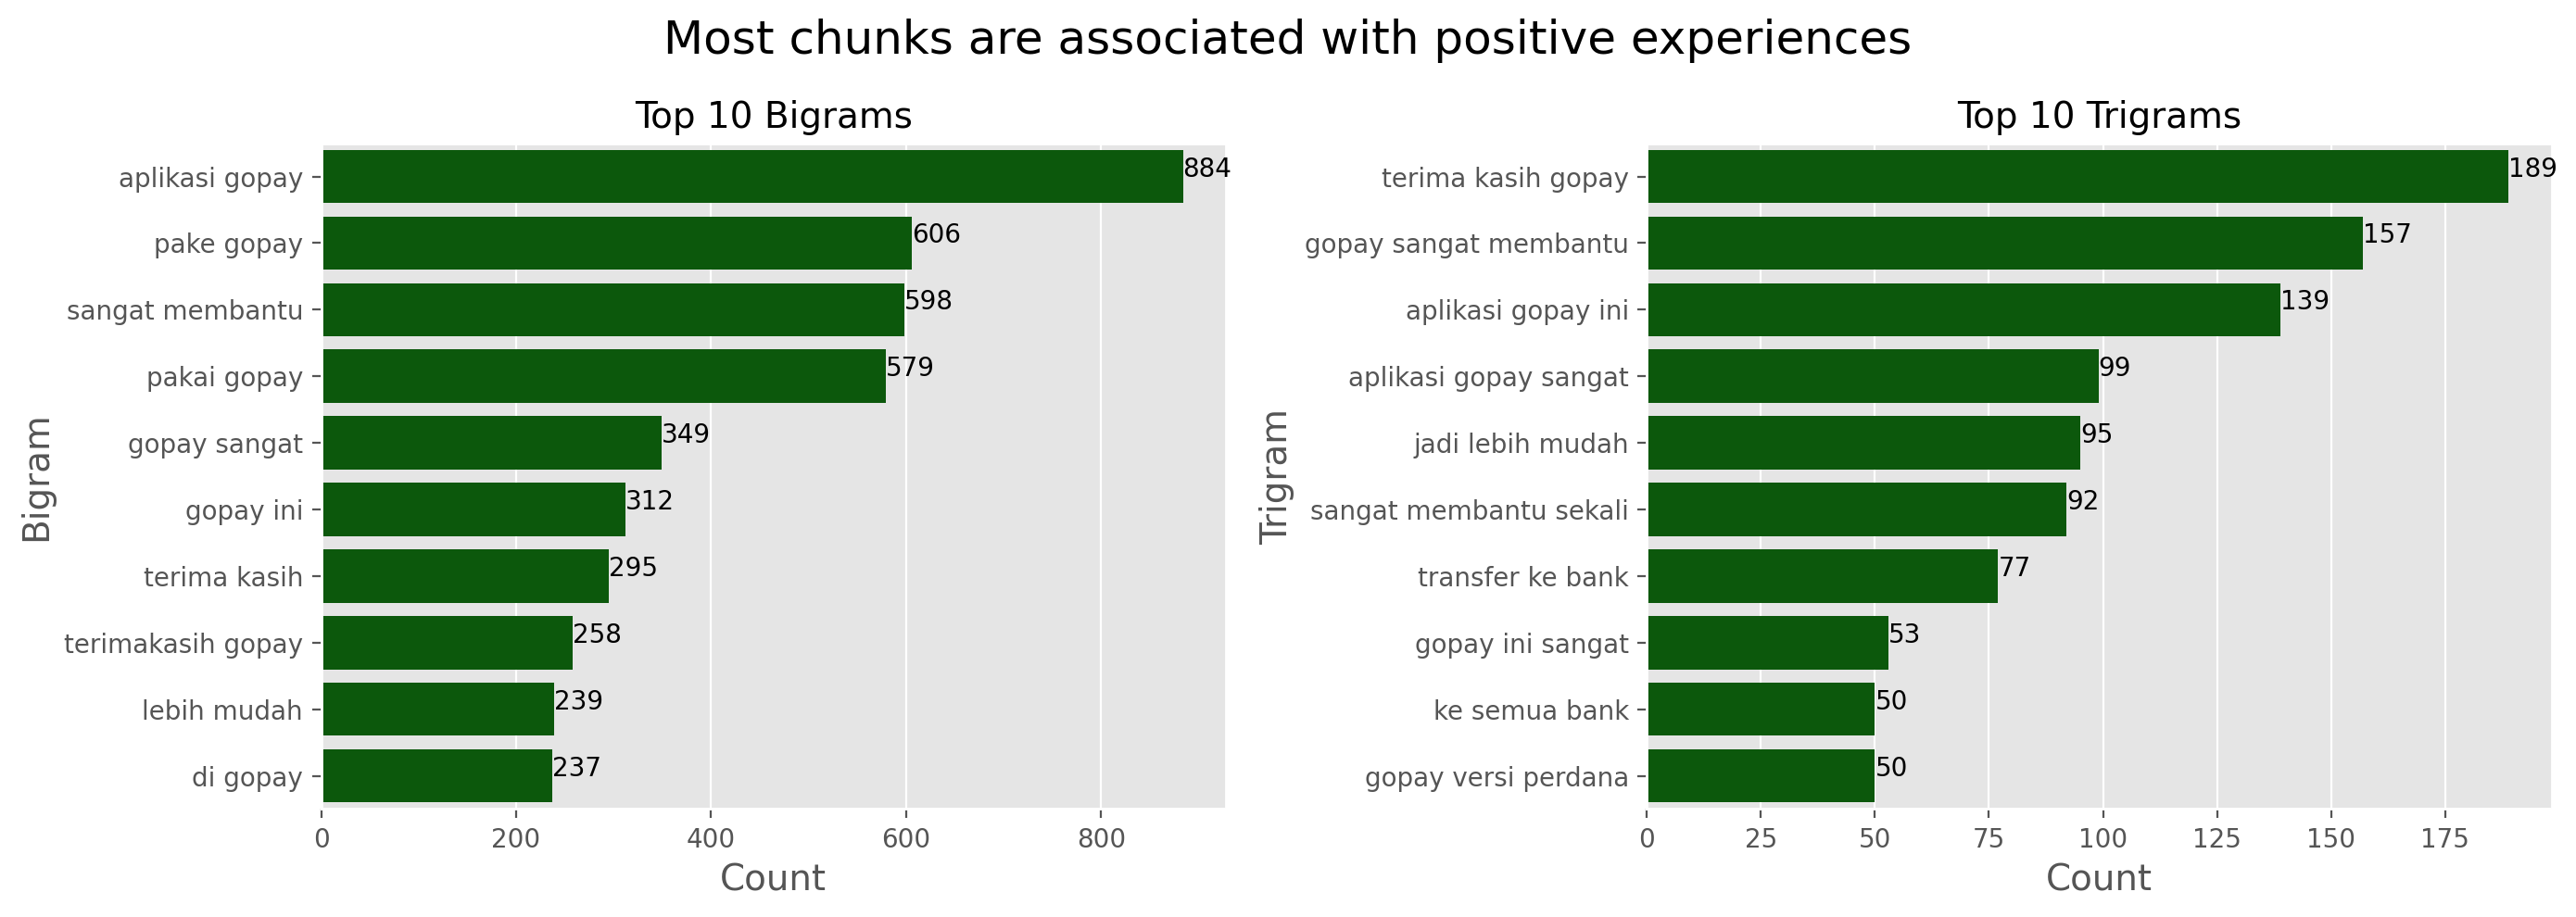

In [52]:
# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# plot for bigrams
sns.barplot(x='count', y='ngram', data=bigram_df.head(10),
            ax=axes[0], color='darkgreen')
for index, value in enumerate(bigram_df.head(10)['count']):
    axes[0].text(value, index, str(value))
axes[0].set_title('Top 10 Bigrams', fontsize=14)
axes[0].set_xlabel('Count', fontsize=14)
axes[0].set_ylabel('Bigram', fontsize=14)

# plot for trigrams
sns.barplot(x='count', y='ngram', data=trigram_df.head(10),
            ax=axes[1], color='darkgreen')
for index, value in enumerate(trigram_df.head(10)['count']):
    axes[1].text(value, index, str(value))
axes[1].set_title('Top 10 Trigrams', fontsize=14)
axes[1].set_xlabel('Count', fontsize=14)
axes[1].set_ylabel('Trigram', fontsize=14)
plt.suptitle('Most chunks are associated with positive experiences',
             size=18)
plt.tight_layout()
plt.show()

**Note**: Both bigrams and trigrams of reviews with 5-rating scores indicate positive perceptions about the app. The positive perceptions can be seen from the word combination *gopay sangat membantu*, *terima kasih gopay*, *jelas lebih mudah*, and *sangat membantu sekali*. This pattern is dissimilar to that in 1-rating score reviews in which highlight rooms for improvement than the positive side of the app. Among the combinations, including both bigrams and trigrams, only phrase *transfer ke bank* and *ke semua bank* indicate specific strengths of the app. Phrases including *gopay* are also prevalent but it remains unclear how *transfer ke bank* relate to the wider co-text. To clarify the co-text, I will use bigram to see immediate context.

In [53]:
# find co-occurrences 
co_occurrences = []
for i in range(len(tokens) - 1):
    if tokens[i] == "aplikasi" and i < len(tokens) - 1 and tokens[i + 1] == "gopay":
        # look at words before and after the phrase
        if i > 0 and tokens[i - 1] not in stop_words:                # word before, not a stopword
            co_occurrences.append(tokens[i - 1])  
        if i + 2 < len(tokens) and tokens[i + 2] not in stop_words:  # word after, not a stopword
            co_occurrences.append(tokens[i + 2])  

# count the frequency 
co_occurrence_counts = Counter(co_occurrences)

In [54]:
# Display the results
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['Word', 'Frequency'])
co_occurrence_df = co_occurrence_df.sort_values(by='Frequency', ascending=False)

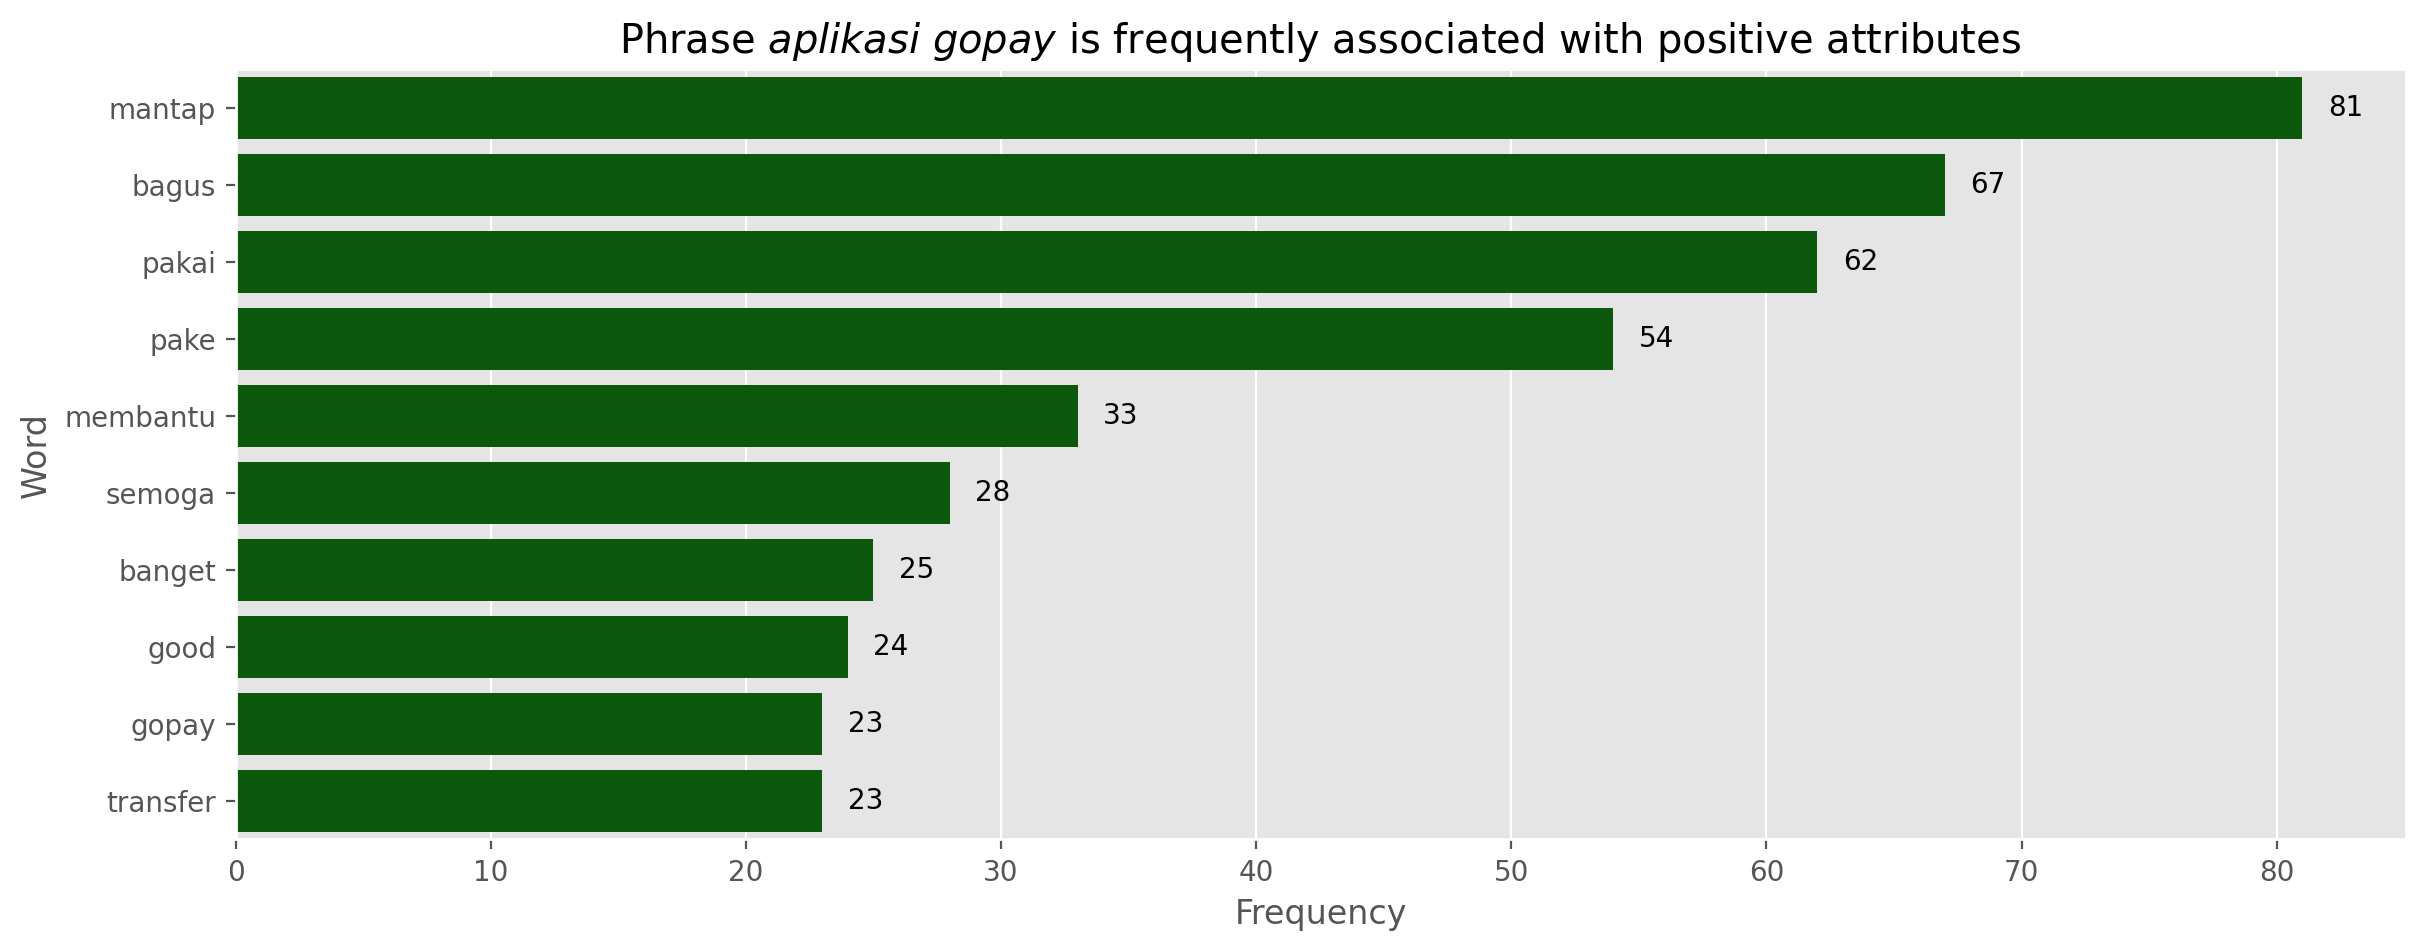

In [55]:
plt.figure(figsize=(14, 5), dpi=200)
sns.barplot(x='Frequency', y='Word', data=co_occurrence_df.head(10), legend=False, color='darkgreen')
for index, value in enumerate(co_occurrence_df['Frequency'].head(10)):
    plt.text(value + 1, index, str(value), va='center')

plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Phrase $aplikasi$ $gopay$ is frequently associated with positive attributes')
plt.show()

**Note**: There are adjectives indicating positive perceptions about phrase *aplikasi gopay* such as *mantap*, *bagus*, and *good*. In addition to these modifiers, verb *membantu* also signifies positive perception about the app. And similar to the previous findings, *transfer* also appears here as a word frequently co-occurring with *aplikasi gopay*. To understand how the verb *transfer* is used within its immediate context better, I will sample the records.

In [56]:
strength_df = df4[(df4['score'] == 5) & (df4['content'].str.contains('transfer ke bank'))]
print(f'Number of records containing \'transfer ke bank\': {len(strength_df)}')
display(strength_df.sample(n=5, random_state=42)
        .loc[:, ['userName', 'content', 'thumbsUpCount', 'reviewCreatedVersion']])

Number of records containing 'transfer ke bank': 299


,userName,content,thumbsUpCount,reviewCreatedVersion
117338,Pengguna Google,"kalo udah pake gopay, gak bakal ngerasa ribet lagi transfer ke bank lain, serba praktis dan smooth!",0,Undefined
111989,Pengguna Google,Aman untuk simpan uang dan transfer ke bank lain,0,1.6.1
86641,Pengguna Google,aplikasi yg bagus untuk transfer ke bank gak kena admin,1,1.14.0
3022,Pengguna Google,"Aplikasi gopay sangat membantu Bisa untu bayar listrik,transfer ke bank manapun bisa ,ovo,dana ,beli pulsa,dll Pokoknya mantap lah",0,1.22.0
50074,Pengguna Google,"Cukup bagus, free admin lg klo mao transfer ke bank lain",1,1.18.1


**Note**: From limited samples, the phrase *transfer ke bank* is used with adjectives such as *praktis dan smooth*, *aman*, *bagus*, *mantap*, and *free admin*, underscoring good user experience with the app. To know about the versions in which *transfer ke bank* occurs, let us see the bar chart below.

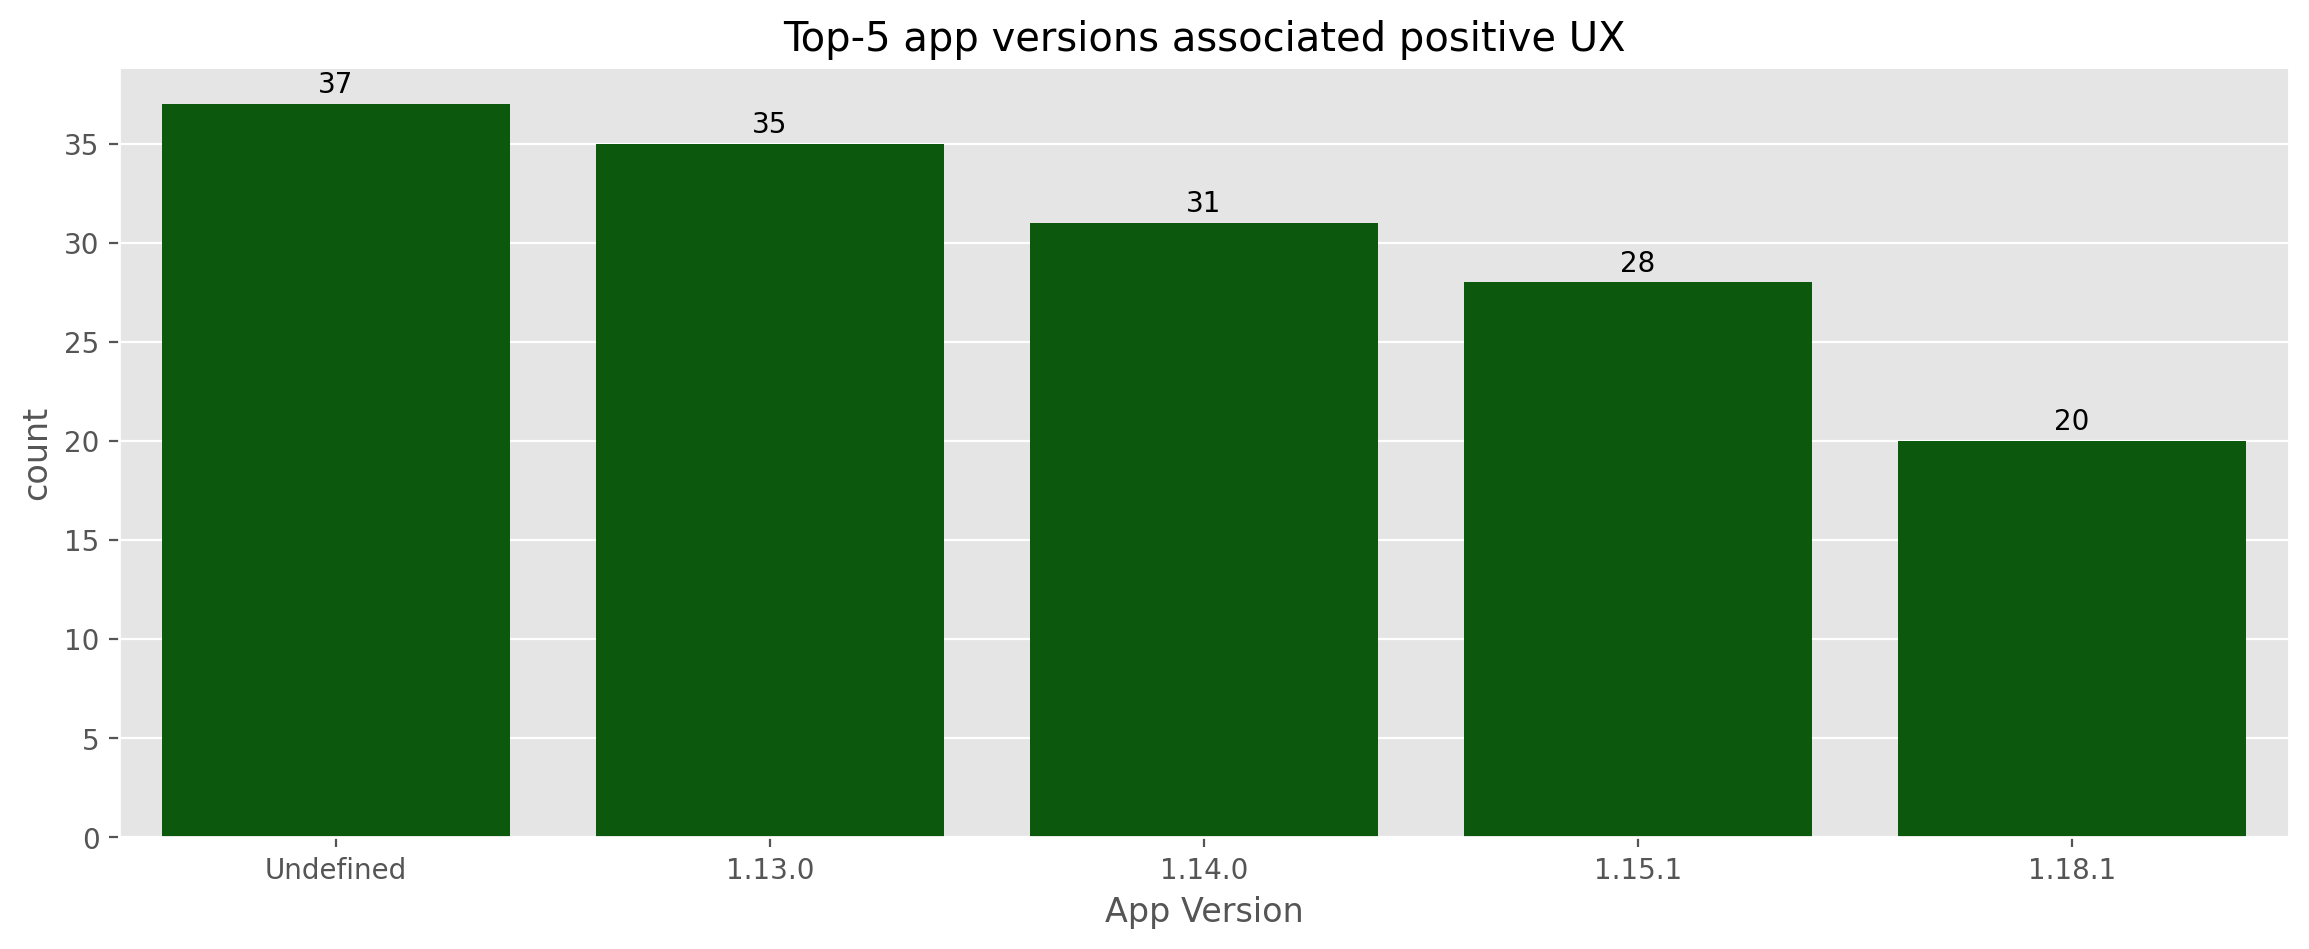

In [57]:
strength_version = (strength_df['reviewCreatedVersion']
                    .value_counts()
                    .reset_index()
                    .head(5))

plt.figure(figsize=(14, 5), dpi=200)
sns.barplot(y='count', x='reviewCreatedVersion', data=strength_version, 
            legend=False, color='darkgreen')
for index, value in enumerate(strength_version['count']):
    plt.text(index, value + 0.25, str(value), ha='center', 
             va='bottom', fontsize=10)
plt.title('Top-5 app versions associated positive UX')
plt.xlabel('App Version')
plt.show()

### **3.5 Summary**
This section aims to investigate app user reviews based on different variables, namely user engagement, time, app version, and content. 
- The user engagement takes a look at the patterns of user satisfaction according to the CSAT scores the users provided when providing reviews on the Play Store. As shown previously, users are in general satisfied with the app. The majority of app users gave rating score of 5.
- The temporal analysis suggests that in the beginning, the satisfaction score was low but it got better aftr 3 months of the app release. The average satisfaction score plateaued out high above 4 (range 1 and 5), indicating consistent statisfaction over time
- The analysis on the app versions revealed that during the early development of the app, users gave low rating scores. This situation is possibly driven by bugs on the app, leading to user frustrations. This finding highlights the temporal analysis, indicating the lower satisfaction score in the early app release. 
- The content analysis took both words and word combinations into account. This analysis indicates that the more user satisfied with the app, the shorter their reviews are. For example, high rated reviews typically contain *mantap* (*amazing*), signaling user satisfaction. In the word-level of analysis, high rated and low rated scores reveal different word selections. For instance, reviews with rating score 5 commonly contain praises about the app via word *mantap*, *bagus*, and *mudah*. Reviews with 1 rating score, however, usually contain negation marks (*ga* or *gak*) and activities such as *transaksi* (*transaction*), *transfer* (*transfer*), and *masuk* (*login*), suggesting app usability-related problems. The analysis on the word-combination level, focusing on words around *gopay* further strengthen the evidence for the high and low rated reviews. High rated reviews are usually associated with praises whereas the low rated ones mostly indicated some rooms for improvements related to usability. 

<h1 style='color:orange; text-align:center; font-weight:bold; font-style:italic'>--Move on to Notebook 2--</h1>